In [2]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.metrics import pairwise_distances

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from sklearn.kernel_ridge import KernelRidge

from mcmodels.core import Mask,ModelData,VoxelModelCache
from mcmodels.core.utils import get_structure_id, get_ordered_summary_structures,get_minorstructures,get_loss_paper
from mcmodels.utils import nonzero_unique, unionize
from mcmodels.core.experiment import get_voxeldata_msvd
from mcmodels.models.crossvalidation import get_best_hyperparameters,get_loss_best_hyp,get_loocv_predictions,get_loss
from mcmodels.core.utils import get_cre_status,get_minorstructure_dictionary,get_leaves_ontologicalorder
from mcmodels.core.utils import get_regionalized_normalized_data
from mcmodels.core.utils import get_connectivity
from mcmodels.core.utils import get_ontological_order_leaf
from mcmodels.core.utils import get_nw_loocv,get_wt_inds
from mcmodels.core.utils import get_countvec

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
#read data
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
FILE_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
OUTPUT_DIR = os.path.join(FILE_DIR, 'output')

input_data = ju.read(INPUT_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)

#its unclear why the hyperparameters are loaded from the output directory
cache = VoxelModelCache(manifest_file=manifest_file)
major_structures = input_data.get('structures')
major_structure_ids = [get_structure_id(cache, s) for s in major_structures]
data_info = pd.read_excel('/Users/samsonkoelle/alleninstitute/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
data_info.set_index("id", inplace=True)
ontological_order = get_ordered_summary_structures(cache)

mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
st = mcc.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}

#regionalize voxel model: compare with regional model
#regional parameters
cre = None
eid_set=None
high_res=False
threshold_injection = False

COARSE_STRUCTURE_SET_ID = 2
DEFAULT_STRUCTURE_SET_IDS = tuple([COARSE_STRUCTURE_SET_ID])
tree = cache.get_structure_tree()
default_structures = tree.get_structures_by_set_id(DEFAULT_STRUCTURE_SET_IDS)
default_structure_ids = [st['id'] for st in default_structures if st['id'] != 934]
#cre= True

In [4]:
msvds = {}
#gammas = np.asarray([0.1])
for sid in major_structure_ids:
    print(sid)
    voxel_data = ModelData(cache, sid)
    print(cre)
    experiment_ids = voxel_data.get_experiment_ids(experiments_exclude=experiments_exclude, cre=cre)
    experiment_ids = np.asarray(list(experiment_ids))    
    msvd = get_voxeldata_msvd(cache, sid,experiments_exclude,default_structure_ids,cre)
    #msvd.l2losses, msvd.paperlosses,msvd.normspredict,msvd.normtrue = single_region_cv(msvd, gammas)
    msvds[sid]  = msvd

512
None
703
None
1089
None
1097
None
315
None
313
None
354
None
698
None
771
None
803
None
477
None
549
None


In [5]:
#get dictionaries of creline and leaf by experiment
creline = get_cre_status(data_info, msvds)
with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
    
#get dictionary of minor structures for each experiment in each major division
#major division segregation is legacy code but convenient for fast cross validation in major division model
experiments_minor_structures = get_minorstructure_dictionary(msvds, data_info)

#get leaves in ontological order.  Where leafs don't exist, uses summary structure
ontological_order_leaves = get_leaves_ontologicalorder(msvd, ontological_order)

#Key isn't affected by which experiment we choose. This allows default masking to be inherited from the AllenSDK.
key = list(msvd.experiments.keys())[0]

#Identify keys denoting which voxels correspond to which structure in the ipsi and contra targets.
#contra_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=1)
#ipsi_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=2)
contra_targetkey = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=1)
ipsi_targetkey = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)

#get average intensities of projection structures given ipsi and contra keys
source_key = ontological_order #only relevant here when injection needs to be unionized, but currently a required argument
msvds = get_regionalized_normalized_data(msvds,cache, source_key,ipsi_targetkey,contra_targetkey)

#wt_2ormore = get_wt_inds(creline)

In [6]:
from sklearn.metrics.pairwise import pairwise_kernels
from mcmodels.regressors.nonparametric.nadaraya_watson import get_weights

def get_best_hyperparameters(losses, keys):
    
    major_structure_ids = np.asarray(list(losses.keys()))
    nms = len(major_structure_ids)
    nkey = keys.shape[1]
    output = np.empty((nms, nkey))
    for m in range(nms):
        print(m)
        sid = major_structure_ids[m]
        lvec = np.asarray([np.nanmean(losses[sid][key]) for key in keys])
        if np.any(~np.isnan(lvec)):
            output[m] = keys[np.nanargmin(lvec)]
        # if len(np.where(np.isnan(np.nanmean(losses[sid][:,:], axis = 1)))[0]) < losses[sid].shape[0]:
        #    output[m] = np.nanargmin(np.nanmean(losses[sid][:,:], axis = 1))

    output = np.asarray(output, dtype=int)
    return(output)

#get where we actually modelled
def get_eval_indices(eval_index_matrices):
    eval_indices = {}
    major_structure_ids = np.asarray(list(eval_index_matrices.keys()))
    for sid in major_structure_ids:
        eval_indices[sid] = np.where(eval_index_matrices[sid].sum(axis = 0) > 0)[0]
    return(eval_indices)    



def get_weights(eval_centroids, model_centroids, gamma):
    weights = pairwise_kernels(X=eval_centroids, Y=model_centroids, metric='rbf', gamma=gamma, filter_params=True)
    return (weights)


def get_indices(ids):

    ids_unique = np.unique(ids)
    output = np.zeros((len(ids_unique), len(ids)), dtype = int)
    for i in range(len(ids_unique)):
        output[i,np.where(ids == ids_unique[i])[0] ] = 1
    return(output)

#get indices of firstlist in firstlisttest in categories defined by secondlist
def get_indices2(firstlist, firstlisttest, secondlist):
    
    sl_unique = np.unique(secondlist)
    output = np.zeros((len(sl_unique), len(secondlist)), dtype = int)
    for i in range(len(sl_unique)):
        output[i,np.intersect1d(np.where(np.isin(firstlist,firstlisttest))[0], np.where(secondlist == sl_unique[i])[0])] = 1
    return(output)

#nmodels = nleafs
#populate each with experiments that share summary structure
def get_indices_summaryinleaf(summarylist , leaflist):
    
    nexp = len(leaflist)
    leaf_unique = np.unique(leaflist)
    output = np.zeros((len(leaf_unique), nexp), dtype = int)
    
    for i in range(len(leaf_unique)):
        
        summary = summarylist[np.where(leaflist == leaf_unique[i])[0]][0]
        output[i,np.where(summarylist == summary)[0]] = 1
        
        
    return(output)

#get predictions at all eval_indices using model_indices
#if an eval_indices is also a model indice, leave it out of the model
#if a model index is not an eval index, it never gets left out
def get_nwloocv_predictions_singlemodel(projections, centroids, gamma, model_indices, eval_indices):
  
    eval_index_val = np.where(eval_indices == 1)[0]
    model_index_val = np.where(model_indices == 1)[0]
    
    projections = np.asarray(projections, dtype=np.float32)
    
    nmod_ind = len(model_index_val)
    neval = len(eval_index_val)
    #nexp = centroids.shape[0]
    predictions = np.empty(projections.shape)
    #print(model_index_val.shape, eval_index_val.shape)

    if len(model_index_val) > 0 and  len(eval_index_val) > 0:
        weights = pairwise_kernels(centroids[model_index_val], centroids[eval_index_val], metric='rbf', gamma=gamma, filter_params=True) #get_weights(centroids, gamma)
        for i in range(neval):
            matchindex = np.where(model_index_val == eval_index_val[i])[0]
            otherindices = np.setdiff1d(np.asarray(list(range(nmod_ind))), matchindex)         
            #this order of operations is the fastest I found
            weights_i = weights[:,i] / weights[:,i][otherindices].sum()
            weights_i[matchindex] = 0
            weights_i = np.asarray(weights_i, dtype=np.float32)
            pred = np.dot(weights_i, projections[model_index_val])
            predictions[eval_index_val[i]] = pred

        
    return(predictions)    

def get_nwloocv_predictions_multimodel(projections, centroids, gammas, model_index_matrix, eval_index_matrix):
    

    
    ntargets = projections.shape[1]
    nexp = projections.shape[0]
    nmodels = model_index_matrix.shape[0]
    ngammas = len(gammas)
    
    projections = np.asarray(projections, dtype=np.float32)
    predictions = np.empty((nmodels, ngammas, nexp, ntargets))
    
    
    for m in range(nmodels):
        #print('m', m, len(np.where(model_index_matrix[m] ==1)[0]))
        predictions[m] = np.asarray([get_nwloocv_predictions_singlemodel(projections, centroids, gammas[g], model_index_matrix[m], eval_index_matrix[m]) for g in range(ngammas)])
    
    return(predictions)  

def combine_predictions(predictions, eval_index_matrix):
    
    nmodels, ngammas, nexp, ntargets = predictions.shape
    combined_predictions = np.empty((ngammas, nexp, ntargets))
    for m in range(nmodels):
        combined_predictions[:,np.where(eval_index_matrix[m] == 1)[0]] = predictions[m][:,np.where(eval_index_matrix[m] == 1)[0]]
        
    return(combined_predictions)

def get_nwloocv_predictions_multimodel_merge(projections, centroids, gammas, model_index_matrix, eval_index_matrix):
    
    predictions_unmerged = get_nwloocv_predictions_multimodel(projections, centroids, gammas, model_index_matrix, eval_index_matrix)
    print(predictions_unmerged.shape)
    predictions_merged = combine_predictions(predictions_unmerged, eval_index_matrix)
    
    return(predictions_merged)

#we should not pass model_index_matrices that are identical to eval_index_matrices and have only 1 element per model
#although in principal we could do automatically in the cross validation code 
#we would rather do it explicitly to ensure identical indexing b/w experiments
#if we only have 1 model index we will remove the model index from eval indices
def screen_indices(model_indices, eval_indices):
    
    eval_indices2 = eval_indices.copy()
    mod_loc = np.where(model_indices == 1)[0]
    if len(mod_loc) == 1:
        eval_indices2[mod_loc] = 0
    return(eval_indices2)

#this could result in an empty eval index i.e. certain indices having no prediction.  catch later
#can merge (sum) the index matrix to see where predictions are actually generated
def screen_index_matrices(model_index_matrices, eval_index_matrices):
    
    #alter eval_indices to remove model index in cases where there is only one experiment in the model
    
    nmodels = model_index_matrices.shape[0]
    eval_index_matrices2 = eval_index_matrices.copy()
    for m in range(nmodels):
        eval_index_matrices2[m] = screen_indices(model_index_matrices[m], eval_index_matrices[m])
    
    return(eval_index_matrices2)

#need code for removing experiments that have no model
#this can happen when the model set is a subset of the evaluation set.
#we will therefore generate predictions for a subset
#given a leaf is included, the eval set is the same
#however, we want to remove evals in leaves we don't have a wt for... of course one could say we are doing worse...
#but we also have a fewer number of models
#model_index_matrices are the indices of the leafs'
#indices_wtinleaf are the wild types
#need to make sure we dont have leafs with only 1 experiment


def screen_index_matrices2(model_index_matrices, eval_index_matrices):
    
    #alter model and eval matrices to be nonzero only when there are at least two experiments in the model
    #it can be useful for when model_index_matrices is a subset of eval_index_matrices
    #nmodels = model_index_matrices.shape[0]
    include_per_model = model_index_matrices.sum(axis= 1)
    to_exclude = np.where(include_per_model <= 1)[0]
    #to_include = np.where(include_per_model > 0)[0]
    
    model_index_matrices2 = model_index_matrices.copy()
    eval_index_matrices2 = eval_index_matrices.copy()
    model_index_matrices2[to_exclude] = 0
    eval_index_matrices2[to_exclude] = 0
    
    return(model_index_matrices2, eval_index_matrices2)

def screen_index_matrices3(model_index_matrices, eval_index_matrices):
    
    #alter model and eval matrices to be nonzero only when there are at least one experiments in the model
    #it can be useful for when model_index_matrices is a subset of eval_index_matrices
    #nmodels = model_index_matrices.shape[0]
    include_per_model = model_index_matrices.sum(axis= 1)
    to_exclude = np.where(include_per_model < 1)[0]
    #to_include = np.where(include_per_model > 0)[0]
    
    model_index_matrices2 = model_index_matrices.copy()
    eval_index_matrices2 = eval_index_matrices.copy()
    model_index_matrices2[to_exclude] = 0
    eval_index_matrices2[to_exclude] = 0
    
    to_remove = np.where(include_per_model == 1)[0]
    eval_index_matrices2[to_remove] = 0
    
    return(model_index_matrices2, eval_index_matrices2)

def get_cre_similarity(msvd, cres,eminors,colnames):

    ss = np.append(['cre','injsum'],colnames)
    ns = np.concatenate([np.empty(2, dtype = str), np.repeat('ipsi',291), np.repeat('contra',286)])
    colns = np.vstack([ns,ss]).transpose()
    clns = list(zip(*colns.transpose()))
    clnsmi = pd.MultiIndex.from_tuples(clns, names=['first', 'second'])
    data_merged = pd.DataFrame(np.hstack([np.expand_dims(cres,1),np.expand_dims(eminors,1),msvd.reg_proj_vcount_norm_renorm ]), columns= clnsmi)
    data_melted = pd.melt(data_merged, id_vars=[('','cre'),('','injsum')])
    data_melted = data_melted.astype({'value': np.float64})
    means = data_melted.groupby(by=['first', 'second',('','cre'),('','injsum')])['value'].mean().reset_index()
    means = means.astype({'value': np.float64})
    means_cast = pd.pivot_table(means, index = [('','cre'),('','injsum')], columns = ['first', 'second'])
    cs = np.asarray(list(means_cast.index))    
    return(means_cast,cs)

In [7]:
import math

# def get_cre_dist_cv(msvd, means_cast, eminors,cres):
#     nsamp = cres.shape[0]
#     credist = np.empty((nsamp,nsamp))
#     credist[:] = np.nan
#     for i in range(nsamp):
#         print(i)
#         #get mean of all points sharing cre line and minor structure with this one (but not including)
#         meani = means_cast.loc[tuple([eminors[i],cres[i]])]
#         ncr = len(np.where(cres == cres[i])[0])
#         meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* msvd.reg_proj_vcount_norm_renorm[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
#         #rkeys = list(results[eminors[i]].keys())#np.asarray(list(results[experiments_minor_structures[sid][i]].keys()))
#         for j in range(nsamp):
#             meanj = means_cast.loc[cres[j]]
#             #t= tuple([cres[i], cres[j]])
#             if np.isin(t, rkeys).all():
#                 credist[i,j]  = np.linalg.norm(meanloocvi - meanj)
#     return(credist)
def get_cre_dist_cv(msvd, means_cast, eminors,cres):
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        print(i)
        #get mean of all points sharing cre line and minor structure with this one (but not including)
        meani = means_cast.loc[tuple([cres[i], eminors[i]])]
        ncr = len(np.where(cres == cres[i])[0])
        meanloocvi = meani
        meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* msvd.reg_proj_vcount_norm_renorm[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
        #rkeys = list(results[eminors[i]].keys())#np.asarray(list(results[experiments_minor_structures[sid][i]].keys()))
        for j in range(nsamp):
            meanj = means_cast.loc[tuple([cres[j], eminors[j]])]
            #t= tuple([cres[i], cres[j]])
            #if np.isin(t, rkeys).all():
            if eminors[j] == eminors[i]:
                credist[i,j]  = np.linalg.norm(meanloocvi - meanj)

    return(credist)

def get_loss_surface(msvd,cre_dist, fraction):
    #ds = pairwise_distances(msvd.centroids)**2
    cs = cre_dist
    #ls = pairwise_distances(msvd.reg_proj_vcount_norm_renorm)**2
    nsamp = msvd.centroids.shape[0]
    #need source and target color
    source = np.repeat(np.linspace(0,nsamp - 1, nsamp, dtype = int), nsamp)
    target = np.tile(np.linspace(0,nsamp - 1, nsamp, dtype = int), nsamp)
    goodpairs = np.asarray(np.where(~np.isnan(cs))).transpose()
    ngp = goodpairs.shape[0]
    centroids = msvd.centroids
    projs = msvd.reg_proj_vcount_norm_renorm
    ds2 = np.zeros(ngp)
    ls2 = np.zeros(ngp)
    for i in range(ngp):
        print(i)
        ds2[i] = np.linalg.norm(centroids[goodpairs[i][0]] - centroids[goodpairs[i][1]])**2
        ls2[i] = np.linalg.norm(projs[goodpairs[i][0]] - projs[goodpairs[i][1]])**2
        
    cs2 = cs[np.where(~np.isnan(cs))]    
    #ds2 = ds[np.where(~np.isnan(cs))]
    #
    source2 = source[np.where(~np.isnan(cs.flatten()))]
    target2 = target[np.where(~np.isnan(cs.flatten()))]

    dsnorm  = np.linalg.norm(ds2)
    csnorm = np.linalg.norm(cs2)

    ds2 = ds2 / dsnorm
    cs2 = cs2 / csnorm
    #ls2 = ls[np.where(~np.isnan(cs))]

    dc = np.asarray([ds2,cs2,ls2]).transpose()
    #ids = np.linspace(0,35, 36, dtype = int), 36)
    
    qqq = KernelRidge(kernel='rbf', alpha=0, gamma  = .05)
    randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
    qqq.fit(dc[:,:2][randos], dc[:,2:][randos])
    #return(qqq)
    return(qqq)

def get_smoothed_losses(msvd, qqq, cre_dist):
    ds = pairwise_distances(msvd.centroids)**2
    cs = cre_dist
    ds2 = ds[np.where(~np.isnan(cs))]
    cs2 = cs[np.where(~np.isnan(cs))]
    dsnorm  = np.linalg.norm(ds2)
    csnorm = np.linalg.norm(cs2)
    
    ls = pairwise_distances(msvd.reg_proj_vcount_norm_renorm)**2
    nsamp = ds.shape[0]
    bbbb = np.asarray(np.where(~np.isnan(cs))).transpose()
    smoothedlosses = np.empty((nsamp,nsamp))
    smoothedlosses[:] = np.nan
    for i in range(bbbb.shape[0]):
        ci = cs[bbbb[i,0], bbbb[i,1]] / csnorm
        di = ds[bbbb[i,0], bbbb[i,1]] / dsnorm
        smoothedlosses[bbbb[i,0], bbbb[i,1]] = qqq.predict(np.asarray([[ci, di]]))
    return(smoothedlosses)

In [26]:
msvds[315].experiments[293472335].injection_density.shape

(132, 80, 114)

In [19]:
msvds[315].injections[40].sum() #this was masked then divided by injection density sum

0.9778195

In [23]:
msvds[315].injections[303].sum() #this was masked then divided by injection density sum

0.92841727

In [24]:
msvds[315].injections[303].shape

(61878,)

In [25]:
injection_mask = Mask.from_cache(cache,structure_ids=[315],hemisphere_id=2)

In [29]:
injection_mask.mask_volume(msvds[315].experiments[514314707].injection_density).max()

0.99940276

In [31]:
msvds[315].experiments[514314707].injection_density.max()

0.99940276

In [27]:
list(msvds[315].experiments.keys())[303]

514314707

In [8]:
indices_leaf = {}
indices_wtinleaf = {}
indices_wtleaf = {}
indices_summary = {}
indices_summaryinleaf = {}
indices_major = {}
indices_majorinleaf = {}
indices_leaf2ormore = {}
indices_wtinleaf2ormore = {}
indices_leaf_reduced = {}
indices_wtinleaf_reduced = {}
indices_wt_leaf2ormore = {}
indices_leaf2ormore_wt = {}
indices_wt1ormore_leaf2ormore = {}
indices_leaf2ormore_wt1ormore = {}
for sid in major_structure_ids:
    
    #wt_leaf on leaf

    #get the indices of experiments sharing leafs (nmodels is number of leafs)
    indices_leaf[sid] = get_indices(leafs[sid]) #eval_indices
    #indices_creleaf = get_indices(leafs[sid])
    
    #get the indices of the wts in the leaf (nmodels is number of leafs)
    indices_wtinleaf[sid] = get_indices2(creline[sid], np.asarray(['C57BL/6J']),leafs[sid]) #model_indices
    
    #get indices of experiments sharing summary structure x cre combination (nmodel is number of cre x leaf combinations)
    #indices_wtleaf[sid] = get_indices(creleafs_merged[sid])
    
    #get indices of experiments sharing summary structure(nmodel is number of summary structures)
    indices_summary[sid] = get_indices(experiments_minor_structures[sid])
    
    #get indices of experiments sharing major structure(nmodel is number of summary structures)
    indices_major[sid] = np.ones((1,experiments_minor_structures[sid].shape[0]))
    
    #get indices of experiments sharing same major structure as a leaf (nmodel is number of leafs)
    indices_majorinleaf[sid] = np.ones((len(np.unique(leafs[sid])),experiments_minor_structures[sid].shape[0]))#get_indices2(np.ones(len(leafs[sid])), np.asarray([1]),leafs[sid]) #model_indices
    
    #get indices of experiments in same summary structure as a leaf (nmodel is number of leafs)
    indices_summaryinleaf[sid] = get_indices_summaryinleaf(experiments_minor_structures[sid], leafs[sid])
    
    #evaluate models on leafs
    indices_leaf2ormore[sid] = screen_index_matrices(indices_leaf[sid], indices_leaf[sid])
    
    indices_wt1ormore_leaf2ormore[sid], indices_leaf2ormore_wt1ormore[sid] = screen_index_matrices3(indices_wtinleaf[sid], indices_leaf2ormore[sid])
    
    indices_wtinleaf2ormore[sid] = screen_index_matrices(indices_wtinleaf[sid], indices_wtinleaf[sid])
    indices_leaf_reduced[sid], indices_wtinleaf_reduced[sid]  = screen_index_matrices2( indices_leaf2ormore[sid],indices_wtinleaf[sid])


In [9]:
ipsi_target_regions, ipsi_target_counts = nonzero_unique(ipsi_targetkey, return_counts=True)
contra_target_regions, contra_target_counts = nonzero_unique(contra_targetkey, return_counts=True)
target_order = lambda x: np.array(ontological_order)[np.isin(ontological_order, x)]
permutation = lambda x: np.argsort(np.argsort(target_order(x)))
targ_ids = np.concatenate([ipsi_target_regions[permutation(ipsi_target_regions)],
                           contra_target_regions[permutation(contra_target_regions)]])
colnames = np.asarray([ia_map[targ_ids[i]] for i in range(len(targ_ids))])

In [10]:
def get_cre_dist_cv(msvd, means_cast, eminors,cres):
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        print(i)
        #get mean of all points sharing cre line and minor structure with this one (but not including)
        meani = means_cast.loc[tuple([cres[i], eminors[i]])]
#         ncr = len(np.where(cres == cres[i])[0])
        ls = np.where(leafs[sid] == leafs[sid][i])[0]
        crs = np.where(cres == cres[i])[0]
        ncr = len(np.intersect1d(ls, crs))
        
        meanloocvi = meani
        if ncr > 1:
            meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* msvd.reg_proj_vcount_norm_renorm[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
        else:
            meanloocvi = np.zeros(msvd.reg_proj_vcount_norm_renorm[i].shape[0])
            meanloocvi[:] = np.nan
            
        #this was originally
        #print(meanloocvi.max(), 'max', ncr)

        #meanloocvi = meani
        #meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* msvd.reg_proj_vcount_norm_renorm[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
        #rkeys = list(results[eminors[i]].keys())#np.asarray(list(results[experiments_minor_structures[sid][i]].keys()))
        for j in range(nsamp):
            meanj = means_cast.loc[tuple([cres[j], eminors[j]])]
            #t= tuple([cres[i], cres[j]])
            #if np.isin(t, rkeys).all():
            if eminors[j] == eminors[i]:
                credist[i,j]  = np.linalg.norm(meanloocvi - meanj)

    return(credist)

In [11]:
#wrong dist (not remove)... try to recreate old result
frac_learn = np.ones(12)
frac_learn[4] = .01
sls = {}
for m in range(4,5):
    sid = major_structure_ids[m]#[np.asarray([0,1,2,3,4,5,6,7,8,9,10,11], dtype = int)]:
    print(sid)
    msvd = msvds[sid]
    cres = creline[sid]
    eminors = leafs[sid]
    means_cast, cs = get_cre_similarity(msvd, cres,eminors, colnames)
    #mean_dist = get_mean_dist(means_cast)
    cre_dist2 = get_cre_dist_cv(msvd, means_cast, eminors,cres)
    qqq = get_loss_surface(msvd, cre_dist2,frac_learn[m])
    sls[sid] = get_smoothed_losses(msvd,qqq, cre_dist2)

315
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
27

1544
1545
1546
1547
1548
1549
1550
1551
1552
1553
1554
1555
1556
1557
1558
1559
1560
1561
1562
1563
1564
1565
1566
1567
1568
1569
1570
1571
1572
1573
1574
1575
1576
1577
1578
1579
1580
1581
1582
1583
1584
1585
1586
1587
1588
1589
1590
1591
1592
1593
1594
1595
1596
1597
1598
1599
1600
1601
1602
1603
1604
1605
1606
1607
1608
1609
1610
1611
1612
1613
1614
1615
1616
1617
1618
1619
1620
1621
1622
1623
1624
1625
1626
1627
1628
1629
1630
1631
1632
1633
1634
1635
1636
1637
1638
1639
1640
1641
1642
1643
1644
1645
1646
1647
1648
1649
1650
1651
1652
1653
1654
1655
1656
1657
1658
1659
1660
1661
1662
1663
1664
1665
1666
1667
1668
1669
1670
1671
1672
1673
1674
1675
1676
1677
1678
1679
1680
1681
1682
1683
1684
1685
1686
1687
1688
1689
1690
1691
1692
1693
1694
1695
1696
1697
1698
1699
1700
1701
1702
1703
1704
1705
1706
1707
1708
1709
1710
1711
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723
1724
1725
1726
1727
1728
1729
1730
1731
1732
1733
1734
1735
1736
1737
1738
1739
1740
1741
1742
1743


4539
4540
4541
4542
4543
4544
4545
4546
4547
4548
4549
4550
4551
4552
4553
4554
4555
4556
4557
4558
4559
4560
4561
4562
4563
4564
4565
4566
4567
4568
4569
4570
4571
4572
4573
4574
4575
4576
4577
4578
4579
4580
4581
4582
4583
4584
4585
4586
4587
4588
4589
4590
4591
4592
4593
4594
4595
4596
4597
4598
4599
4600
4601
4602
4603
4604
4605
4606
4607
4608
4609
4610
4611
4612
4613
4614
4615
4616
4617
4618
4619
4620
4621
4622
4623
4624
4625
4626
4627
4628
4629
4630
4631
4632
4633
4634
4635
4636
4637
4638
4639
4640
4641
4642
4643
4644
4645
4646
4647
4648
4649
4650
4651
4652
4653
4654
4655
4656
4657
4658
4659
4660
4661
4662
4663
4664
4665
4666
4667
4668
4669
4670
4671
4672
4673
4674
4675
4676
4677
4678
4679
4680
4681
4682
4683
4684
4685
4686
4687
4688
4689
4690
4691
4692
4693
4694
4695
4696
4697
4698
4699
4700
4701
4702
4703
4704
4705
4706
4707
4708
4709
4710
4711
4712
4713
4714
4715
4716
4717
4718
4719
4720
4721
4722
4723
4724
4725
4726
4727
4728
4729
4730
4731
4732
4733
4734
4735
4736
4737
4738


7624
7625
7626
7627
7628
7629
7630
7631
7632
7633
7634
7635
7636
7637
7638
7639
7640
7641
7642
7643
7644
7645
7646
7647
7648
7649
7650
7651
7652
7653
7654
7655
7656
7657
7658
7659
7660
7661
7662
7663
7664
7665
7666
7667
7668
7669
7670
7671
7672
7673
7674
7675
7676
7677
7678
7679
7680
7681
7682
7683
7684
7685
7686
7687
7688
7689
7690
7691
7692
7693
7694
7695
7696
7697
7698
7699
7700
7701
7702
7703
7704
7705
7706
7707
7708
7709
7710
7711
7712
7713
7714
7715
7716
7717
7718
7719
7720
7721
7722
7723
7724
7725
7726
7727
7728
7729
7730
7731
7732
7733
7734
7735
7736
7737
7738
7739
7740
7741
7742
7743
7744
7745
7746
7747
7748
7749
7750
7751
7752
7753
7754
7755
7756
7757
7758
7759
7760
7761
7762
7763
7764
7765
7766
7767
7768
7769
7770
7771
7772
7773
7774
7775
7776
7777
7778
7779
7780
7781
7782
7783
7784
7785
7786
7787
7788
7789
7790
7791
7792
7793
7794
7795
7796
7797
7798
7799
7800
7801
7802
7803
7804
7805
7806
7807
7808
7809
7810
7811
7812
7813
7814
7815
7816
7817
7818
7819
7820
7821
7822
7823


10723
10724
10725
10726
10727
10728
10729
10730
10731
10732
10733
10734
10735
10736
10737
10738
10739
10740
10741
10742
10743
10744
10745
10746
10747
10748
10749
10750
10751
10752
10753
10754
10755
10756
10757
10758
10759
10760
10761
10762
10763
10764
10765
10766
10767
10768
10769
10770
10771
10772
10773
10774
10775
10776
10777
10778
10779
10780
10781
10782
10783
10784
10785
10786
10787
10788
10789
10790
10791
10792
10793
10794
10795
10796
10797
10798
10799
10800
10801
10802
10803
10804
10805
10806
10807
10808
10809
10810
10811
10812
10813
10814
10815
10816
10817
10818
10819
10820
10821
10822
10823
10824
10825
10826
10827
10828
10829
10830
10831
10832
10833
10834
10835
10836
10837
10838
10839
10840
10841
10842
10843
10844
10845
10846
10847
10848
10849
10850
10851
10852
10853
10854
10855
10856
10857
10858
10859
10860
10861
10862
10863
10864
10865
10866
10867
10868
10869
10870
10871
10872
10873
10874
10875
10876
10877
10878
10879
10880
10881
10882
10883
10884
10885
10886
10887
10888
1088

12207
12208
12209
12210
12211
12212
12213
12214
12215
12216
12217
12218
12219
12220
12221
12222
12223
12224
12225
12226
12227
12228
12229
12230
12231
12232
12233
12234
12235
12236
12237
12238
12239
12240
12241
12242
12243
12244
12245
12246
12247
12248
12249
12250
12251
12252
12253
12254
12255
12256
12257
12258
12259
12260
12261
12262
12263
12264
12265
12266
12267
12268
12269
12270
12271
12272
12273
12274
12275
12276
12277
12278
12279
12280
12281
12282
12283
12284
12285
12286
12287
12288
12289
12290
12291
12292
12293
12294
12295
12296
12297
12298
12299
12300
12301
12302
12303
12304
12305
12306
12307
12308
12309
12310
12311
12312
12313
12314
12315
12316
12317
12318
12319
12320
12321
12322
12323
12324
12325
12326
12327
12328
12329
12330
12331
12332
12333
12334
12335
12336
12337
12338
12339
12340
12341
12342
12343
12344
12345
12346
12347
12348
12349
12350
12351
12352
12353
12354
12355
12356
12357
12358
12359
12360
12361
12362
12363
12364
12365
12366
12367
12368
12369
12370
12371
12372
1237

13791
13792
13793
13794
13795
13796
13797
13798
13799
13800
13801
13802
13803
13804
13805
13806
13807
13808
13809
13810
13811
13812
13813
13814
13815
13816
13817
13818
13819
13820
13821
13822
13823
13824
13825
13826
13827
13828
13829
13830
13831
13832
13833
13834
13835
13836
13837
13838
13839
13840
13841
13842
13843
13844
13845
13846
13847
13848
13849
13850
13851
13852
13853
13854
13855
13856
13857
13858
13859
13860
13861
13862
13863
13864
13865
13866
13867
13868
13869
13870
13871
13872
13873
13874
13875
13876
13877
13878
13879
13880
13881
13882
13883
13884
13885
13886
13887
13888
13889
13890
13891
13892
13893
13894
13895
13896
13897
13898
13899
13900
13901
13902
13903
13904
13905
13906
13907
13908
13909
13910
13911
13912
13913
13914
13915
13916
13917
13918
13919
13920
13921
13922
13923
13924
13925
13926
13927
13928
13929
13930
13931
13932
13933
13934
13935
13936
13937
13938
13939
13940
13941
13942
13943
13944
13945
13946
13947
13948
13949
13950
13951
13952
13953
13954
13955
13956
1395

15360
15361
15362
15363
15364
15365
15366
15367
15368
15369
15370
15371
15372
15373
15374
15375
15376
15377
15378
15379
15380
15381
15382
15383
15384
15385
15386
15387
15388
15389
15390
15391
15392
15393
15394
15395
15396
15397
15398
15399
15400
15401
15402
15403
15404
15405
15406
15407
15408
15409
15410
15411
15412
15413
15414
15415
15416
15417
15418
15419
15420
15421
15422
15423
15424
15425
15426
15427
15428
15429
15430
15431
15432
15433
15434
15435
15436
15437
15438
15439
15440
15441
15442
15443
15444
15445
15446
15447
15448
15449
15450
15451
15452
15453
15454
15455
15456
15457
15458
15459
15460
15461
15462
15463
15464
15465
15466
15467
15468
15469
15470
15471
15472
15473
15474
15475
15476
15477
15478
15479
15480
15481
15482
15483
15484
15485
15486
15487
15488
15489
15490
15491
15492
15493
15494
15495
15496
15497
15498
15499
15500
15501
15502
15503
15504
15505
15506
15507
15508
15509
15510
15511
15512
15513
15514
15515
15516
15517
15518
15519
15520
15521
15522
15523
15524
15525
1552

16928
16929
16930
16931
16932
16933
16934
16935
16936
16937
16938
16939
16940
16941
16942
16943
16944
16945
16946
16947
16948
16949
16950
16951
16952
16953
16954
16955
16956
16957
16958
16959
16960
16961
16962
16963
16964
16965
16966
16967
16968
16969
16970
16971
16972
16973
16974
16975
16976
16977
16978
16979
16980
16981
16982
16983
16984
16985
16986
16987
16988
16989
16990
16991
16992
16993
16994
16995
16996
16997
16998
16999
17000
17001
17002
17003
17004
17005
17006
17007
17008
17009
17010
17011
17012
17013
17014
17015
17016
17017
17018
17019
17020
17021
17022
17023
17024
17025
17026
17027
17028
17029
17030
17031
17032
17033
17034
17035
17036
17037
17038
17039
17040
17041
17042
17043
17044
17045
17046
17047
17048
17049
17050
17051
17052
17053
17054
17055
17056
17057
17058
17059
17060
17061
17062
17063
17064
17065
17066
17067
17068
17069
17070
17071
17072
17073
17074
17075
17076
17077
17078
17079
17080
17081
17082
17083
17084
17085
17086
17087
17088
17089
17090
17091
17092
17093
1709

18420
18421
18422
18423
18424
18425
18426
18427
18428
18429
18430
18431
18432
18433
18434
18435
18436
18437
18438
18439
18440
18441
18442
18443
18444
18445
18446
18447
18448
18449
18450
18451
18452
18453
18454
18455
18456
18457
18458
18459
18460
18461
18462
18463
18464
18465
18466
18467
18468
18469
18470
18471
18472
18473
18474
18475
18476
18477
18478
18479
18480
18481
18482
18483
18484
18485
18486
18487
18488
18489
18490
18491
18492
18493
18494
18495
18496
18497
18498
18499
18500
18501
18502
18503
18504
18505
18506
18507
18508
18509
18510
18511
18512
18513
18514
18515
18516
18517
18518
18519
18520
18521
18522
18523
18524
18525
18526
18527
18528
18529
18530
18531
18532
18533
18534
18535
18536
18537
18538
18539
18540
18541
18542
18543
18544
18545
18546
18547
18548
18549
18550
18551
18552
18553
18554
18555
18556
18557
18558
18559
18560
18561
18562
18563
18564
18565
18566
18567
18568
18569
18570
18571
18572
18573
18574
18575
18576
18577
18578
18579
18580
18581
18582
18583
18584
18585
1858

19892
19893
19894
19895
19896
19897
19898
19899
19900
19901
19902
19903
19904
19905
19906
19907
19908
19909
19910
19911
19912
19913
19914
19915
19916
19917
19918
19919
19920
19921
19922
19923
19924
19925
19926
19927
19928
19929
19930
19931
19932
19933
19934
19935
19936
19937
19938
19939
19940
19941
19942
19943
19944
19945
19946
19947
19948
19949
19950
19951
19952
19953
19954
19955
19956
19957
19958
19959
19960
19961
19962
19963
19964
19965
19966
19967
19968
19969
19970
19971
19972
19973
19974
19975
19976
19977
19978
19979
19980
19981
19982
19983
19984
19985
19986
19987
19988
19989
19990
19991
19992
19993
19994
19995
19996
19997
19998
19999
20000
20001
20002
20003
20004
20005
20006
20007
20008
20009
20010
20011
20012
20013
20014
20015
20016
20017
20018
20019
20020
20021
20022
20023
20024
20025
20026
20027
20028
20029
20030
20031
20032
20033
20034
20035
20036
20037
20038
20039
20040
20041
20042
20043
20044
20045
20046
20047
20048
20049
20050
20051
20052
20053
20054
20055
20056
20057
2005

21448
21449
21450
21451
21452
21453
21454
21455
21456
21457
21458
21459
21460
21461
21462
21463
21464
21465
21466
21467
21468
21469
21470
21471
21472
21473
21474
21475
21476
21477
21478
21479
21480
21481
21482
21483
21484
21485
21486
21487
21488
21489
21490
21491
21492
21493
21494
21495
21496
21497
21498
21499
21500
21501
21502
21503
21504
21505
21506
21507
21508
21509
21510
21511
21512
21513
21514
21515
21516
21517
21518
21519
21520
21521
21522
21523
21524
21525
21526
21527
21528
21529
21530
21531
21532
21533
21534
21535
21536
21537
21538
21539
21540
21541
21542
21543
21544
21545
21546
21547
21548
21549
21550
21551
21552
21553
21554
21555
21556
21557
21558
21559
21560
21561
21562
21563
21564
21565
21566
21567
21568
21569
21570
21571
21572
21573
21574
21575
21576
21577
21578
21579
21580
21581
21582
21583
21584
21585
21586
21587
21588
21589
21590
21591
21592
21593
21594
21595
21596
21597
21598
21599
21600
21601
21602
21603
21604
21605
21606
21607
21608
21609
21610
21611
21612
21613
2161

22963
22964
22965
22966
22967
22968
22969
22970
22971
22972
22973
22974
22975
22976
22977
22978
22979
22980
22981
22982
22983
22984
22985
22986
22987
22988
22989
22990
22991
22992
22993
22994
22995
22996
22997
22998
22999
23000
23001
23002
23003
23004
23005
23006
23007
23008
23009
23010
23011
23012
23013
23014
23015
23016
23017
23018
23019
23020
23021
23022
23023
23024
23025
23026
23027
23028
23029
23030
23031
23032
23033
23034
23035
23036
23037
23038
23039
23040
23041
23042
23043
23044
23045
23046
23047
23048
23049
23050
23051
23052
23053
23054
23055
23056
23057
23058
23059
23060
23061
23062
23063
23064
23065
23066
23067
23068
23069
23070
23071
23072
23073
23074
23075
23076
23077
23078
23079
23080
23081
23082
23083
23084
23085
23086
23087
23088
23089
23090
23091
23092
23093
23094
23095
23096
23097
23098
23099
23100
23101
23102
23103
23104
23105
23106
23107
23108
23109
23110
23111
23112
23113
23114
23115
23116
23117
23118
23119
23120
23121
23122
23123
23124
23125
23126
23127
23128
2312

24487
24488
24489
24490
24491
24492
24493
24494
24495
24496
24497
24498
24499
24500
24501
24502
24503
24504
24505
24506
24507
24508
24509
24510
24511
24512
24513
24514
24515
24516
24517
24518
24519
24520
24521
24522
24523
24524
24525
24526
24527
24528
24529
24530
24531
24532
24533
24534
24535
24536
24537
24538
24539
24540
24541
24542
24543
24544
24545
24546
24547
24548
24549
24550
24551
24552
24553
24554
24555
24556
24557
24558
24559
24560
24561
24562
24563
24564
24565
24566
24567
24568
24569
24570
24571
24572
24573
24574
24575
24576
24577
24578
24579
24580
24581
24582
24583
24584
24585
24586
24587
24588
24589
24590
24591
24592
24593
24594
24595
24596
24597
24598
24599
24600
24601
24602
24603
24604
24605
24606
24607
24608
24609
24610
24611
24612
24613
24614
24615
24616
24617
24618
24619
24620
24621
24622
24623
24624
24625
24626
24627
24628
24629
24630
24631
24632
24633
24634
24635
24636
24637
24638
24639
24640
24641
24642
24643
24644
24645
24646
24647
24648
24649
24650
24651
24652
2465

26038
26039
26040
26041
26042
26043
26044
26045
26046
26047
26048
26049
26050
26051
26052
26053
26054
26055
26056
26057
26058
26059
26060
26061
26062
26063
26064
26065
26066
26067
26068
26069
26070
26071
26072
26073
26074
26075
26076
26077
26078
26079
26080
26081
26082
26083
26084
26085
26086
26087
26088
26089
26090
26091
26092
26093
26094
26095
26096
26097
26098
26099
26100
26101
26102
26103
26104
26105
26106
26107
26108
26109
26110
26111
26112
26113
26114
26115
26116
26117
26118
26119
26120
26121
26122
26123
26124
26125
26126
26127
26128
26129
26130
26131
26132
26133
26134
26135
26136
26137
26138
26139
26140
26141
26142
26143
26144
26145
26146
26147
26148
26149
26150
26151
26152
26153
26154
26155
26156
26157
26158
26159
26160
26161
26162
26163
26164
26165
26166
26167
26168
26169
26170
26171
26172
26173
26174
26175
26176
26177
26178
26179
26180
26181
26182
26183
26184
26185
26186
26187
26188
26189
26190
26191
26192
26193
26194
26195
26196
26197
26198
26199
26200
26201
26202
26203
2620

27617
27618
27619
27620
27621
27622
27623
27624
27625
27626
27627
27628
27629
27630
27631
27632
27633
27634
27635
27636
27637
27638
27639
27640
27641
27642
27643
27644
27645
27646
27647
27648
27649
27650
27651
27652
27653
27654
27655
27656
27657
27658
27659
27660
27661
27662
27663
27664
27665
27666
27667
27668
27669
27670
27671
27672
27673
27674
27675
27676
27677
27678
27679
27680
27681
27682
27683
27684
27685
27686
27687
27688
27689
27690
27691
27692
27693
27694
27695
27696
27697
27698
27699
27700
27701
27702
27703
27704
27705
27706
27707
27708
27709
27710
27711
27712
27713
27714
27715
27716
27717
27718
27719
27720
27721
27722
27723
27724
27725
27726
27727
27728
27729
27730
27731
27732
27733
27734
27735
27736
27737
27738
27739
27740
27741
27742
27743
27744
27745
27746
27747
27748
27749
27750
27751
27752
27753
27754
27755
27756
27757
27758
27759
27760
27761
27762
27763
27764
27765
27766
27767
27768
27769
27770
27771
27772
27773
27774
27775
27776
27777
27778
27779
27780
27781
27782
2778

29159
29160
29161
29162
29163
29164
29165
29166
29167
29168
29169
29170
29171
29172
29173
29174
29175
29176
29177
29178
29179
29180
29181
29182
29183
29184
29185
29186
29187
29188
29189
29190
29191
29192
29193
29194
29195
29196
29197
29198
29199
29200
29201
29202
29203
29204
29205
29206
29207
29208
29209
29210
29211
29212
29213
29214
29215
29216
29217
29218
29219
29220
29221
29222
29223
29224
29225
29226
29227
29228
29229
29230
29231
29232
29233
29234
29235
29236
29237
29238
29239
29240
29241
29242
29243
29244
29245
29246
29247
29248
29249
29250
29251
29252
29253
29254
29255
29256
29257
29258
29259
29260
29261
29262
29263
29264
29265
29266
29267
29268
29269
29270
29271
29272
29273
29274
29275
29276
29277
29278
29279
29280
29281
29282
29283
29284
29285
29286
29287
29288
29289
29290
29291
29292
29293
29294
29295
29296
29297
29298
29299
29300
29301
29302
29303
29304
29305
29306
29307
29308
29309
29310
29311
29312
29313
29314
29315
29316
29317
29318
29319
29320
29321
29322
29323
29324
2932

30637
30638
30639
30640
30641
30642
30643
30644
30645
30646
30647
30648
30649
30650
30651
30652
30653
30654
30655
30656
30657
30658
30659
30660
30661
30662
30663
30664
30665
30666
30667
30668
30669
30670
30671
30672
30673
30674
30675
30676
30677
30678
30679
30680
30681
30682
30683
30684
30685
30686
30687
30688
30689
30690
30691
30692
30693
30694
30695
30696
30697
30698
30699
30700
30701
30702
30703
30704
30705
30706
30707
30708
30709
30710
30711
30712
30713
30714
30715
30716
30717
30718
30719
30720
30721
30722
30723
30724
30725
30726
30727
30728
30729
30730
30731
30732
30733
30734
30735
30736
30737
30738
30739
30740
30741
30742
30743
30744
30745
30746
30747
30748
30749
30750
30751
30752
30753
30754
30755
30756
30757
30758
30759
30760
30761
30762
30763
30764
30765
30766
30767
30768
30769
30770
30771
30772
30773
30774
30775
30776
30777
30778
30779
30780
30781
30782
30783
30784
30785
30786
30787
30788
30789
30790
30791
30792
30793
30794
30795
30796
30797
30798
30799
30800
30801
30802
3080

32101
32102
32103
32104
32105
32106
32107
32108
32109
32110
32111
32112
32113
32114
32115
32116
32117
32118
32119
32120
32121
32122
32123
32124
32125
32126
32127
32128
32129
32130
32131
32132
32133
32134
32135
32136
32137
32138
32139
32140
32141
32142
32143
32144
32145
32146
32147
32148
32149
32150
32151
32152
32153
32154
32155
32156
32157
32158
32159
32160
32161
32162
32163
32164
32165
32166
32167
32168
32169
32170
32171
32172
32173
32174
32175
32176
32177
32178
32179
32180
32181
32182
32183
32184
32185
32186
32187
32188
32189
32190
32191
32192
32193
32194
32195
32196
32197
32198
32199
32200
32201
32202
32203
32204
32205
32206
32207
32208
32209
32210
32211
32212
32213
32214
32215
32216
32217
32218
32219
32220
32221
32222
32223
32224
32225
32226
32227
32228
32229
32230
32231
32232
32233
32234
32235
32236
32237
32238
32239
32240
32241
32242
32243
32244
32245
32246
32247
32248
32249
32250
32251
32252
32253
32254
32255
32256
32257
32258
32259
32260
32261
32262
32263
32264
32265
32266
3226

33689
33690
33691
33692
33693
33694
33695
33696
33697
33698
33699
33700
33701
33702
33703
33704
33705
33706
33707
33708
33709
33710
33711
33712
33713
33714
33715
33716
33717
33718
33719
33720
33721
33722
33723
33724
33725
33726
33727
33728
33729
33730
33731
33732
33733
33734
33735
33736
33737
33738
33739
33740
33741
33742
33743
33744
33745
33746
33747
33748
33749
33750
33751
33752
33753
33754
33755
33756
33757
33758
33759
33760
33761
33762
33763
33764
33765
33766
33767
33768
33769
33770
33771
33772
33773
33774
33775
33776
33777
33778
33779
33780
33781
33782
33783
33784
33785
33786
33787
33788
33789
33790
33791
33792
33793
33794
33795
33796
33797
33798
33799
33800
33801
33802
33803
33804
33805
33806
33807
33808
33809
33810
33811
33812
33813
33814
33815
33816
33817
33818
33819
33820
33821
33822
33823
33824
33825
33826
33827
33828
33829
33830
33831
33832
33833
33834
33835
33836
33837
33838
33839
33840
33841
33842
33843
33844
33845
33846
33847
33848
33849
33850
33851
33852
33853
33854
3385

35255
35256
35257
35258
35259
35260
35261
35262
35263
35264
35265
35266
35267
35268
35269
35270
35271
35272
35273
35274
35275
35276
35277
35278
35279
35280
35281
35282
35283
35284
35285
35286
35287
35288
35289
35290
35291
35292
35293
35294
35295
35296
35297
35298
35299
35300
35301
35302
35303
35304
35305
35306
35307
35308
35309
35310
35311
35312
35313
35314
35315
35316
35317
35318
35319
35320
35321
35322
35323
35324
35325
35326
35327
35328
35329
35330
35331
35332
35333
35334
35335
35336
35337
35338
35339
35340
35341
35342
35343
35344
35345
35346
35347
35348
35349
35350
35351
35352
35353
35354
35355
35356
35357
35358
35359
35360
35361
35362
35363
35364
35365
35366
35367
35368
35369
35370
35371
35372
35373
35374
35375
35376
35377
35378
35379
35380
35381
35382
35383
35384
35385
35386
35387
35388
35389
35390
35391
35392
35393
35394
35395
35396
35397
35398
35399
35400
35401
35402
35403
35404
35405
35406
35407
35408
35409
35410
35411
35412
35413
35414
35415
35416
35417
35418
35419
35420
3542

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


In [18]:

def get_nwloocv_predictions_singlemodel_dists(projections, dists, gamma, model_indices, eval_indices):
  
    eval_index_val = np.where(eval_indices == 1)[0]
    model_index_val = np.where(model_indices == 1)[0]
    
    projections = np.asarray(projections, dtype=np.float32)
    
    nmod_ind = len(model_index_val)
    neval = len(eval_index_val)
    #nexp = centroids.shape[0]
    predictions = np.empty(projections.shape)
    #print(model_index_val.shape, eval_index_val.shape)

    if len(model_index_val) > 0 and  len(eval_index_val) > 0:
        weights = np.exp(-dists[model_index_val][:, eval_index_val] * gamma)#np.exp(-dists[model_index_val] / gamma) #get_weights(centroids, gamma)
        for i in range(neval):
            matchindex = np.where(model_index_val == eval_index_val[i])[0]
            otherindices = np.setdiff1d(np.asarray(list(range(nmod_ind))), matchindex)         
            #this order of operations is the fastest I found
            weights_i = weights[i,:] / np.nansum(weights[i,:][otherindices])
            #print(np.nansum(weights[:,i][otherindices]))
            weights_i[matchindex] = 0
            weights_i = np.asarray(weights_i, dtype=np.float32)
            weights_i[np.isnan(weights_i)] = 0.
            pred = np.dot(weights_i, projections[model_index_val])
            predictions[eval_index_val[i]] = pred

        
    return(predictions) 

def get_nwloocv_predictions_multimodel_merge_dists(projections, dists, gammas, model_index_matrix, eval_index_matrix):
    
    predictions_unmerged = get_nwloocv_predictions_multimodel_dists(projections, dists, gammas, model_index_matrix, eval_index_matrix)
    print(predictions_unmerged.shape)
    predictions_merged = combine_predictions(predictions_unmerged, eval_index_matrix)
    
    return(predictions_merged)
    
    
def get_nwloocv_predictions_multimodel_dists(projections, dists, gammas, model_index_matrix, eval_index_matrix):
    

    
    ntargets = projections.shape[1]
    nexp = projections.shape[0]
    nmodels = model_index_matrix.shape[0]
    ngammas = len(gammas)
    
    projections = np.asarray(projections, dtype=np.float32)
    predictions = np.empty((nmodels, ngammas, nexp, ntargets))
    
    
    for m in range(nmodels):
        #print('m', m, len(np.where(model_index_matrix[m] ==1)[0]))
        predictions[m] = np.asarray([get_nwloocv_predictions_singlemodel_dists(projections, dists, gammas[g], model_index_matrix[m], eval_index_matrix[m]) for g in range(ngammas)])
    
    return(predictions)  


In [13]:

creleafs = {}
creleafs_merged = {}
for sid in major_structure_ids:
    creleafs[sid] = np.asarray(np.vstack([leafs[sid], creline[sid]]), dtype = str).transpose()
    creleafs_merged[sid] = [creleafs[sid][:,0][i]  + creleafs[sid][:,1][i] for i in range(creleafs[sid].shape[0])]
    
indices_creleaf = {}
indices_creleaf2ormore = {}
for sid in major_structure_ids:
    indices_creleaf[sid] = get_indices(np.asarray(creleafs_merged[sid]))
    indices_creleaf2ormore[sid] = screen_index_matrices(indices_creleaf[sid], indices_creleaf[sid])

eval_indices_creleaf2ormore = get_eval_indices(indices_creleaf2ormore)

In [19]:
gammas = np.asarray([0.1,.5,1,2,10])
for sid in major_structure_ids[4:5]:
    msvds[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge_dists(msvds[sid].reg_proj_vcount_norm_renorm, 
                                                                                       sls[sid], 
                                                                                       gammas, 
                                                                                       indices_leaf2ormore[sid], 
                                                                                       indices_leaf2ormore[sid])
a= [list(range(5))]
keys = np.asarray(list(itertools.product(*a)))

reg_proj_vcount_norm_renorms= {}
nwloocv_leaf_leaf2 = {}
for sid in major_structure_ids[4:5]:
    reg_proj_vcount_norm_renorms[sid ] = msvds[sid].reg_proj_vcount_norm_renorm
    nwloocv_leaf_leaf2[sid] = msvds[sid].loocv_predictions_leaf_leaf2

eval_indices_creleaf2ormore = get_eval_indices(indices_creleaf2ormore)

losses_leaf_leaf2 = get_loss(reg_proj_vcount_norm_renorms, nwloocv_leaf_leaf2,pred_ind = eval_indices_creleaf2ormore, true_ind = eval_indices_creleaf2ormore,keys = keys)
best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
meanloss_nw_leaf_leaf2 = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

(119, 5, 1128, 577)
0


In [20]:
best_gamma_leaf_leaf2

array([[4]])

In [21]:
meanloss_nw_leaf_leaf2

array([0.26591056])

In [16]:
best_gamma_leaf_leaf2

array([[0]])

In [17]:
meanloss_nw_leaf_leaf2

array([0.26591056])

In [22]:

def get_nwloocv_predictions_singlemodel_dists_near(projections, dists, gamma, model_indices, eval_indices):
  
    eval_index_val = np.where(eval_indices == 1)[0]
    model_index_val = np.where(model_indices == 1)[0]
    
    projections = np.asarray(projections, dtype=np.float32)
    
    nmod_ind = len(model_index_val)
    neval = len(eval_index_val)
    #nexp = centroids.shape[0]
    predictions = np.empty(projections.shape)
    #print(model_index_val.shape, eval_index_val.shape)

    if len(model_index_val) > 0 and  len(eval_index_val) > 0:
        weights = np.exp(-dists[model_index_val][:, eval_index_val] * gamma)#np.exp(-dists[model_index_val] / gamma) #get_weights(centroids, gamma)
        for i in range(neval):
            matchindex = np.where(model_index_val == eval_index_val[i])[0]
            otherindices = np.setdiff1d(np.asarray(list(range(nmod_ind))), matchindex)         
            #this order of operations is the fastest I found
            weights_i = weights[i,:] / np.nansum(weights[i,:][otherindices])
            #print(np.nansum(weights[:,i][otherindices]))
            weights_i[matchindex] = 0
            weights_i = np.asarray(weights_i, dtype=np.float32)
            weights_i[np.isnan(weights_i)] = 0.
            if np.sum(weights_i) > 0.:
                #print('here')
                pred = np.dot(weights_i, projections[model_index_val])
            else:
                print('here')
                am = np.argmin(dists[model_index_val[otherindices]][:, eval_index_val[i]])
                pred = projections[model_index_val[otherindices[am]]]
            predictions[eval_index_val[i]] = pred

        
    return(predictions) 

def get_nwloocv_predictions_multimodel_merge_dists_near(projections, dists, gammas, model_index_matrix, eval_index_matrix):
    
    predictions_unmerged = get_nwloocv_predictions_multimodel_dists_near(projections, dists, gammas, model_index_matrix, eval_index_matrix)
    print(predictions_unmerged.shape)
    predictions_merged = combine_predictions(predictions_unmerged, eval_index_matrix)
    
    return(predictions_merged)
    
    
def get_nwloocv_predictions_multimodel_dists_near(projections, dists, gammas, model_index_matrix, eval_index_matrix):
    

    
    ntargets = projections.shape[1]
    nexp = projections.shape[0]
    nmodels = model_index_matrix.shape[0]
    ngammas = len(gammas)
    
    projections = np.asarray(projections, dtype=np.float32)
    predictions = np.empty((nmodels, ngammas, nexp, ntargets))
    
    
    for m in range(nmodels):
        #print('m', m, len(np.where(model_index_matrix[m] ==1)[0]))
        predictions[m] = np.asarray([get_nwloocv_predictions_singlemodel_dists_near(projections, dists, gammas[g], model_index_matrix[m], eval_index_matrix[m]) for g in range(ngammas)])
    
    return(predictions)  

In [23]:
gammas = np.asarray([0.1,.5,1,2,10])
for sid in major_structure_ids[4:5]:
    msvds[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge_dists_near(msvds[sid].reg_proj_vcount_norm_renorm, 
                                                                                       sls[sid], 
                                                                                       gammas, 
                                                                                       indices_leaf2ormore[sid], 
                                                                                       indices_leaf2ormore[sid])
a= [list(range(5))]
keys = np.asarray(list(itertools.product(*a)))

reg_proj_vcount_norm_renorms= {}
nwloocv_leaf_leaf2 = {}
for sid in major_structure_ids[4:5]:
    reg_proj_vcount_norm_renorms[sid ] = msvds[sid].reg_proj_vcount_norm_renorm
    nwloocv_leaf_leaf2[sid] = msvds[sid].loocv_predictions_leaf_leaf2

eval_indices_creleaf2ormore = get_eval_indices(indices_creleaf2ormore)

losses_leaf_leaf2 = get_loss(reg_proj_vcount_norm_renorms, nwloocv_leaf_leaf2,pred_ind = eval_indices_creleaf2ormore, true_ind = eval_indices_creleaf2ormore,keys = keys)
best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
meanloss_nw_leaf_leaf2 = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
(119, 5, 1128, 577)
0


In [25]:
best_gamma_leaf_leaf2

array([[4]])

In [26]:
meanloss_nw_leaf_leaf2

array([0.26591056])

In [27]:
meanloss_nw_leaf_leaf2

array([0.36742986, 0.44434151, 0.18212918, 0.25214153, 0.35816118,
       0.3036585 , 0.17514333, 0.37684526, 0.23133565, 0.53121684,
       0.57423787, 0.30444867])

In [50]:
frac_learn = np.ones(12)
frac_learn[4] = .01

In [1]:
msvd

NameError: name 'msvd' is not defined

In [48]:
%matplotlib notebook

m =4
sid = major_structure_ids[m]#[np.asarray([0,1,2,3,4,5,6,7,8,9,10,11], dtype = int)]:
msvd = msvds[sid]
cres = creline[sid]
eminors = leafs[sid]#experiments_minor_structures[sid]
means_cast, cs = get_cre_similarity(msvd, cres,eminors, colnames)
#mean_dist = get_mean_dist(means_cast)
cre_dist2 = get_cre_dist_cv(msvd, means_cast, eminors,cres)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

NameError: name 'frac_learn' is not defined

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

2209
2210
2211
2212
2213
2214
2215
2216
2217
2218
2219
2220
2221
2222
2223
2224
2225
2226
2227
2228
2229
2230
2231
2232
2233
2234
2235
2236
2237
2238
2239
2240
2241
2242
2243
2244
2245
2246
2247
2248
2249
2250
2251
2252
2253
2254
2255
2256
2257
2258
2259
2260
2261
2262
2263
2264
2265
2266
2267
2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278
2279
2280
2281
2282
2283
2284
2285
2286
2287
2288
2289
2290
2291
2292
2293
2294
2295
2296
2297
2298
2299
2300
2301
2302
2303
2304
2305
2306
2307
2308
2309
2310
2311
2312
2313
2314
2315
2316
2317
2318
2319
2320
2321
2322
2323
2324
2325
2326
2327
2328
2329
2330
2331
2332
2333
2334
2335
2336
2337
2338
2339
2340
2341
2342
2343
2344
2345
2346
2347
2348
2349
2350
2351
2352
2353
2354
2355
2356
2357
2358
2359
2360
2361
2362
2363
2364
2365
2366
2367
2368
2369
2370
2371
2372
2373
2374
2375
2376
2377
2378
2379
2380
2381
2382
2383
2384
2385
2386
2387
2388
2389
2390
2391
2392
2393
2394
2395
2396
2397
2398
2399
2400
2401
2402
2403
2404
2405
2406
2407
2408


5064
5065
5066
5067
5068
5069
5070
5071
5072
5073
5074
5075
5076
5077
5078
5079
5080
5081
5082
5083
5084
5085
5086
5087
5088
5089
5090
5091
5092
5093
5094
5095
5096
5097
5098
5099
5100
5101
5102
5103
5104
5105
5106
5107
5108
5109
5110
5111
5112
5113
5114
5115
5116
5117
5118
5119
5120
5121
5122
5123
5124
5125
5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263


7997
7998
7999
8000
8001
8002
8003
8004
8005
8006
8007
8008
8009
8010
8011
8012
8013
8014
8015
8016
8017
8018
8019
8020
8021
8022
8023
8024
8025
8026
8027
8028
8029
8030
8031
8032
8033
8034
8035
8036
8037
8038
8039
8040
8041
8042
8043
8044
8045
8046
8047
8048
8049
8050
8051
8052
8053
8054
8055
8056
8057
8058
8059
8060
8061
8062
8063
8064
8065
8066
8067
8068
8069
8070
8071
8072
8073
8074
8075
8076
8077
8078
8079
8080
8081
8082
8083
8084
8085
8086
8087
8088
8089
8090
8091
8092
8093
8094
8095
8096
8097
8098
8099
8100
8101
8102
8103
8104
8105
8106
8107
8108
8109
8110
8111
8112
8113
8114
8115
8116
8117
8118
8119
8120
8121
8122
8123
8124
8125
8126
8127
8128
8129
8130
8131
8132
8133
8134
8135
8136
8137
8138
8139
8140
8141
8142
8143
8144
8145
8146
8147
8148
8149
8150
8151
8152
8153
8154
8155
8156
8157
8158
8159
8160
8161
8162
8163
8164
8165
8166
8167
8168
8169
8170
8171
8172
8173
8174
8175
8176
8177
8178
8179
8180
8181
8182
8183
8184
8185
8186
8187
8188
8189
8190
8191
8192
8193
8194
8195
8196


10911
10912
10913
10914
10915
10916
10917
10918
10919
10920
10921
10922
10923
10924
10925
10926
10927
10928
10929
10930
10931
10932
10933
10934
10935
10936
10937
10938
10939
10940
10941
10942
10943
10944
10945
10946
10947
10948
10949
10950
10951
10952
10953
10954
10955
10956
10957
10958
10959
10960
10961
10962
10963
10964
10965
10966
10967
10968
10969
10970
10971
10972
10973
10974
10975
10976
10977
10978
10979
10980
10981
10982
10983
10984
10985
10986
10987
10988
10989
10990
10991
10992
10993
10994
10995
10996
10997
10998
10999
11000
11001
11002
11003
11004
11005
11006
11007
11008
11009
11010
11011
11012
11013
11014
11015
11016
11017
11018
11019
11020
11021
11022
11023
11024
11025
11026
11027
11028
11029
11030
11031
11032
11033
11034
11035
11036
11037
11038
11039
11040
11041
11042
11043
11044
11045
11046
11047
11048
11049
11050
11051
11052
11053
11054
11055
11056
11057
11058
11059
11060
11061
11062
11063
11064
11065
11066
11067
11068
11069
11070
11071
11072
11073
11074
11075
11076
1107

12302
12303
12304
12305
12306
12307
12308
12309
12310
12311
12312
12313
12314
12315
12316
12317
12318
12319
12320
12321
12322
12323
12324
12325
12326
12327
12328
12329
12330
12331
12332
12333
12334
12335
12336
12337
12338
12339
12340
12341
12342
12343
12344
12345
12346
12347
12348
12349
12350
12351
12352
12353
12354
12355
12356
12357
12358
12359
12360
12361
12362
12363
12364
12365
12366
12367
12368
12369
12370
12371
12372
12373
12374
12375
12376
12377
12378
12379
12380
12381
12382
12383
12384
12385
12386
12387
12388
12389
12390
12391
12392
12393
12394
12395
12396
12397
12398
12399
12400
12401
12402
12403
12404
12405
12406
12407
12408
12409
12410
12411
12412
12413
12414
12415
12416
12417
12418
12419
12420
12421
12422
12423
12424
12425
12426
12427
12428
12429
12430
12431
12432
12433
12434
12435
12436
12437
12438
12439
12440
12441
12442
12443
12444
12445
12446
12447
12448
12449
12450
12451
12452
12453
12454
12455
12456
12457
12458
12459
12460
12461
12462
12463
12464
12465
12466
12467
1246

13770
13771
13772
13773
13774
13775
13776
13777
13778
13779
13780
13781
13782
13783
13784
13785
13786
13787
13788
13789
13790
13791
13792
13793
13794
13795
13796
13797
13798
13799
13800
13801
13802
13803
13804
13805
13806
13807
13808
13809
13810
13811
13812
13813
13814
13815
13816
13817
13818
13819
13820
13821
13822
13823
13824
13825
13826
13827
13828
13829
13830
13831
13832
13833
13834
13835
13836
13837
13838
13839
13840
13841
13842
13843
13844
13845
13846
13847
13848
13849
13850
13851
13852
13853
13854
13855
13856
13857
13858
13859
13860
13861
13862
13863
13864
13865
13866
13867
13868
13869
13870
13871
13872
13873
13874
13875
13876
13877
13878
13879
13880
13881
13882
13883
13884
13885
13886
13887
13888
13889
13890
13891
13892
13893
13894
13895
13896
13897
13898
13899
13900
13901
13902
13903
13904
13905
13906
13907
13908
13909
13910
13911
13912
13913
13914
13915
13916
13917
13918
13919
13920
13921
13922
13923
13924
13925
13926
13927
13928
13929
13930
13931
13932
13933
13934
13935
1393

15307
15308
15309
15310
15311
15312
15313
15314
15315
15316
15317
15318
15319
15320
15321
15322
15323
15324
15325
15326
15327
15328
15329
15330
15331
15332
15333
15334
15335
15336
15337
15338
15339
15340
15341
15342
15343
15344
15345
15346
15347
15348
15349
15350
15351
15352
15353
15354
15355
15356
15357
15358
15359
15360
15361
15362
15363
15364
15365
15366
15367
15368
15369
15370
15371
15372
15373
15374
15375
15376
15377
15378
15379
15380
15381
15382
15383
15384
15385
15386
15387
15388
15389
15390
15391
15392
15393
15394
15395
15396
15397
15398
15399
15400
15401
15402
15403
15404
15405
15406
15407
15408
15409
15410
15411
15412
15413
15414
15415
15416
15417
15418
15419
15420
15421
15422
15423
15424
15425
15426
15427
15428
15429
15430
15431
15432
15433
15434
15435
15436
15437
15438
15439
15440
15441
15442
15443
15444
15445
15446
15447
15448
15449
15450
15451
15452
15453
15454
15455
15456
15457
15458
15459
15460
15461
15462
15463
15464
15465
15466
15467
15468
15469
15470
15471
15472
1547

18074
18075
18076
18077
18078
18079
18080
18081
18082
18083
18084
18085
18086
18087
18088
18089
18090
18091
18092
18093
18094
18095
18096
18097
18098
18099
18100
18101
18102
18103
18104
18105
18106
18107
18108
18109
18110
18111
18112
18113
18114
18115
18116
18117
18118
18119
18120
18121
18122
18123
18124
18125
18126
18127
18128
18129
18130
18131
18132
18133
18134
18135
18136
18137
18138
18139
18140
18141
18142
18143
18144
18145
18146
18147
18148
18149
18150
18151
18152
18153
18154
18155
18156
18157
18158
18159
18160
18161
18162
18163
18164
18165
18166
18167
18168
18169
18170
18171
18172
18173
18174
18175
18176
18177
18178
18179
18180
18181
18182
18183
18184
18185
18186
18187
18188
18189
18190
18191
18192
18193
18194
18195
18196
18197
18198
18199
18200
18201
18202
18203
18204
18205
18206
18207
18208
18209
18210
18211
18212
18213
18214
18215
18216
18217
18218
18219
18220
18221
18222
18223
18224
18225
18226
18227
18228
18229
18230
18231
18232
18233
18234
18235
18236
18237
18238
18239
1824

20909
20910
20911
20912
20913
20914
20915
20916
20917
20918
20919
20920
20921
20922
20923
20924
20925
20926
20927
20928
20929
20930
20931
20932
20933
20934
20935
20936
20937
20938
20939
20940
20941
20942
20943
20944
20945
20946
20947
20948
20949
20950
20951
20952
20953
20954
20955
20956
20957
20958
20959
20960
20961
20962
20963
20964
20965
20966
20967
20968
20969
20970
20971
20972
20973
20974
20975
20976
20977
20978
20979
20980
20981
20982
20983
20984
20985
20986
20987
20988
20989
20990
20991
20992
20993
20994
20995
20996
20997
20998
20999
21000
21001
21002
21003
21004
21005
21006
21007
21008
21009
21010
21011
21012
21013
21014
21015
21016
21017
21018
21019
21020
21021
21022
21023
21024
21025
21026
21027
21028
21029
21030
21031
21032
21033
21034
21035
21036
21037
21038
21039
21040
21041
21042
21043
21044
21045
21046
21047
21048
21049
21050
21051
21052
21053
21054
21055
21056
21057
21058
21059
21060
21061
21062
21063
21064
21065
21066
21067
21068
21069
21070
21071
21072
21073
21074
2107

23595
23596
23597
23598
23599
23600
23601
23602
23603
23604
23605
23606
23607
23608
23609
23610
23611
23612
23613
23614
23615
23616
23617
23618
23619
23620
23621
23622
23623
23624
23625
23626
23627
23628
23629
23630
23631
23632
23633
23634
23635
23636
23637
23638
23639
23640
23641
23642
23643
23644
23645
23646
23647
23648
23649
23650
23651
23652
23653
23654
23655
23656
23657
23658
23659
23660
23661
23662
23663
23664
23665
23666
23667
23668
23669
23670
23671
23672
23673
23674
23675
23676
23677
23678
23679
23680
23681
23682
23683
23684
23685
23686
23687
23688
23689
23690
23691
23692
23693
23694
23695
23696
23697
23698
23699
23700
23701
23702
23703
23704
23705
23706
23707
23708
23709
23710
23711
23712
23713
23714
23715
23716
23717
23718
23719
23720
23721
23722
23723
23724
23725
23726
23727
23728
23729
23730
23731
23732
23733
23734
23735
23736
23737
23738
23739
23740
23741
23742
23743
23744
23745
23746
23747
23748
23749
23750
23751
23752
23753
23754
23755
23756
23757
23758
23759
23760
2376

25000
25001
25002
25003
25004
25005
25006
25007
25008
25009
25010
25011
25012
25013
25014
25015
25016
25017
25018
25019
25020
25021
25022
25023
25024
25025
25026
25027
25028
25029
25030
25031
25032
25033
25034
25035
25036
25037
25038
25039
25040
25041
25042
25043
25044
25045
25046
25047
25048
25049
25050
25051
25052
25053
25054
25055
25056
25057
25058
25059
25060
25061
25062
25063
25064
25065
25066
25067
25068
25069
25070
25071
25072
25073
25074
25075
25076
25077
25078
25079
25080
25081
25082
25083
25084
25085
25086
25087
25088
25089
25090
25091
25092
25093
25094
25095
25096
25097
25098
25099
25100
25101
25102
25103
25104
25105
25106
25107
25108
25109
25110
25111
25112
25113
25114
25115
25116
25117
25118
25119
25120
25121
25122
25123
25124
25125
25126
25127
25128
25129
25130
25131
25132
25133
25134
25135
25136
25137
25138
25139
25140
25141
25142
25143
25144
25145
25146
25147
25148
25149
25150
25151
25152
25153
25154
25155
25156
25157
25158
25159
25160
25161
25162
25163
25164
25165
2516

27685
27686
27687
27688
27689
27690
27691
27692
27693
27694
27695
27696
27697
27698
27699
27700
27701
27702
27703
27704
27705
27706
27707
27708
27709
27710
27711
27712
27713
27714
27715
27716
27717
27718
27719
27720
27721
27722
27723
27724
27725
27726
27727
27728
27729
27730
27731
27732
27733
27734
27735
27736
27737
27738
27739
27740
27741
27742
27743
27744
27745
27746
27747
27748
27749
27750
27751
27752
27753
27754
27755
27756
27757
27758
27759
27760
27761
27762
27763
27764
27765
27766
27767
27768
27769
27770
27771
27772
27773
27774
27775
27776
27777
27778
27779
27780
27781
27782
27783
27784
27785
27786
27787
27788
27789
27790
27791
27792
27793
27794
27795
27796
27797
27798
27799
27800
27801
27802
27803
27804
27805
27806
27807
27808
27809
27810
27811
27812
27813
27814
27815
27816
27817
27818
27819
27820
27821
27822
27823
27824
27825
27826
27827
27828
27829
27830
27831
27832
27833
27834
27835
27836
27837
27838
27839
27840
27841
27842
27843
27844
27845
27846
27847
27848
27849
27850
2785

30490
30491
30492
30493
30494
30495
30496
30497
30498
30499
30500
30501
30502
30503
30504
30505
30506
30507
30508
30509
30510
30511
30512
30513
30514
30515
30516
30517
30518
30519
30520
30521
30522
30523
30524
30525
30526
30527
30528
30529
30530
30531
30532
30533
30534
30535
30536
30537
30538
30539
30540
30541
30542
30543
30544
30545
30546
30547
30548
30549
30550
30551
30552
30553
30554
30555
30556
30557
30558
30559
30560
30561
30562
30563
30564
30565
30566
30567
30568
30569
30570
30571
30572
30573
30574
30575
30576
30577
30578
30579
30580
30581
30582
30583
30584
30585
30586
30587
30588
30589
30590
30591
30592
30593
30594
30595
30596
30597
30598
30599
30600
30601
30602
30603
30604
30605
30606
30607
30608
30609
30610
30611
30612
30613
30614
30615
30616
30617
30618
30619
30620
30621
30622
30623
30624
30625
30626
30627
30628
30629
30630
30631
30632
30633
30634
30635
30636
30637
30638
30639
30640
30641
30642
30643
30644
30645
30646
30647
30648
30649
30650
30651
30652
30653
30654
30655
3065

32009
32010
32011
32012
32013
32014
32015
32016
32017
32018
32019
32020
32021
32022
32023
32024
32025
32026
32027
32028
32029
32030
32031
32032
32033
32034
32035
32036
32037
32038
32039
32040
32041
32042
32043
32044
32045
32046
32047
32048
32049
32050
32051
32052
32053
32054
32055
32056
32057
32058
32059
32060
32061
32062
32063
32064
32065
32066
32067
32068
32069
32070
32071
32072
32073
32074
32075
32076
32077
32078
32079
32080
32081
32082
32083
32084
32085
32086
32087
32088
32089
32090
32091
32092
32093
32094
32095
32096
32097
32098
32099
32100
32101
32102
32103
32104
32105
32106
32107
32108
32109
32110
32111
32112
32113
32114
32115
32116
32117
32118
32119
32120
32121
32122
32123
32124
32125
32126
32127
32128
32129
32130
32131
32132
32133
32134
32135
32136
32137
32138
32139
32140
32141
32142
32143
32144
32145
32146
32147
32148
32149
32150
32151
32152
32153
32154
32155
32156
32157
32158
32159
32160
32161
32162
32163
32164
32165
32166
32167
32168
32169
32170
32171
32172
32173
32174
3217

33403
33404
33405
33406
33407
33408
33409
33410
33411
33412
33413
33414
33415
33416
33417
33418
33419
33420
33421
33422
33423
33424
33425
33426
33427
33428
33429
33430
33431
33432
33433
33434
33435
33436
33437
33438
33439
33440
33441
33442
33443
33444
33445
33446
33447
33448
33449
33450
33451
33452
33453
33454
33455
33456
33457
33458
33459
33460
33461
33462
33463
33464
33465
33466
33467
33468
33469
33470
33471
33472
33473
33474
33475
33476
33477
33478
33479
33480
33481
33482
33483
33484
33485
33486
33487
33488
33489
33490
33491
33492
33493
33494
33495
33496
33497
33498
33499
33500
33501
33502
33503
33504
33505
33506
33507
33508
33509
33510
33511
33512
33513
33514
33515
33516
33517
33518
33519
33520
33521
33522
33523
33524
33525
33526
33527
33528
33529
33530
33531
33532
33533
33534
33535
33536
33537
33538
33539
33540
33541
33542
33543
33544
33545
33546
33547
33548
33549
33550
33551
33552
33553
33554
33555
33556
33557
33558
33559
33560
33561
33562
33563
33564
33565
33566
33567
33568
3356

34890
34891
34892
34893
34894
34895
34896
34897
34898
34899
34900
34901
34902
34903
34904
34905
34906
34907
34908
34909
34910
34911
34912
34913
34914
34915
34916
34917
34918
34919
34920
34921
34922
34923
34924
34925
34926
34927
34928
34929
34930
34931
34932
34933
34934
34935
34936
34937
34938
34939
34940
34941
34942
34943
34944
34945
34946
34947
34948
34949
34950
34951
34952
34953
34954
34955
34956
34957
34958
34959
34960
34961
34962
34963
34964
34965
34966
34967
34968
34969
34970
34971
34972
34973
34974
34975
34976
34977
34978
34979
34980
34981
34982
34983
34984
34985
34986
34987
34988
34989
34990
34991
34992
34993
34994
34995
34996
34997
34998
34999
35000
35001
35002
35003
35004
35005
35006
35007
35008
35009
35010
35011
35012
35013
35014
35015
35016
35017
35018
35019
35020
35021
35022
35023
35024
35025
35026
35027
35028
35029
35030
35031
35032
35033
35034
35035
35036
35037
35038
35039
35040
35041
35042
35043
35044
35045
35046
35047
35048
35049
35050
35051
35052
35053
35054
35055
3505

36282
36283
36284
36285
36286
36287
36288
36289
36290
36291
36292
36293
36294
36295
36296
36297
36298
36299
36300
36301
36302
36303
36304
36305
36306
36307
36308
36309
36310
36311
36312
36313
36314
36315
36316
36317
36318
36319
36320
36321
36322
36323
36324
36325
36326
36327
36328
36329
36330
36331
36332
36333
36334
36335
36336
36337
36338
36339
36340
36341
36342
36343
36344
36345
36346
36347
36348
36349
36350
36351
36352
36353
36354
36355
36356
36357
36358
36359
36360
36361
36362
36363
36364
36365
36366
36367
36368
36369
36370
36371
36372
36373
36374
36375
36376
36377
36378
36379
36380
36381
36382
36383
36384
36385
36386
36387
36388
36389
36390
36391
36392
36393
36394
36395
36396
36397
36398
36399
36400
36401
36402
36403
36404
36405
36406
36407
36408
36409
36410
36411
36412
36413
36414
36415
36416
36417
36418
36419
36420
36421
36422
36423
36424
36425
36426
36427
36428
36429
36430
36431
36432
36433
36434
36435
36436
36437
36438
36439
36440
36441
36442
36443
36444
36445
36446
36447
3644

37695
37696
37697
37698
37699
37700
37701
37702
37703
37704
37705
37706
37707
37708
37709
37710
37711
37712
37713
37714
37715
37716
37717
37718
37719
37720
37721
37722
37723
37724
37725
37726
37727
37728
37729
37730
37731
37732
37733
37734
37735
37736
37737
37738
37739
37740
37741
37742
37743
37744
37745
37746
37747
37748
37749
37750
37751
37752
37753
37754
37755
37756
37757
37758
37759
37760
37761
37762
37763
37764
37765
37766
37767
37768
37769
37770
37771
37772
37773
37774
37775
37776
37777
37778
37779
37780
37781
37782
37783
37784
37785
37786
37787
37788
37789
37790
37791
37792
37793
37794
37795
37796
37797
37798
37799
37800
37801
37802
37803
37804
37805
37806
37807
37808
37809
37810
37811
37812
37813
37814
37815
37816
37817
37818
37819
37820
37821
37822
37823
37824
37825
37826
37827
37828
37829
37830
37831
37832
37833
37834
37835
37836
37837
37838
37839
37840
37841
37842
37843
37844
37845
37846
37847
37848
37849
37850
37851
37852
37853
37854
37855
37856
37857
37858
37859
37860
3786

39064
39065
39066
39067
39068
39069
39070
39071
39072
39073
39074
39075
39076
39077
39078
39079
39080
39081
39082
39083
39084
39085
39086
39087
39088
39089
39090
39091
39092
39093
39094
39095
39096
39097
39098
39099
39100
39101
39102
39103
39104
39105
39106
39107
39108
39109
39110
39111
39112
39113
39114
39115
39116
39117
39118
39119
39120
39121
39122
39123
39124
39125
39126
39127
39128
39129
39130
39131
39132
39133
39134
39135
39136
39137
39138
39139
39140
39141
39142
39143
39144
39145
39146
39147
39148
39149
39150
39151
39152
39153
39154
39155
39156
39157
39158
39159
39160
39161
39162
39163
39164
39165
39166
39167
39168
39169
39170
39171
39172
39173
39174
39175
39176
39177
39178
39179
39180
39181
39182
39183
39184
39185
39186
39187
39188
39189
39190
39191
39192
39193
39194
39195
39196
39197
39198
39199
39200
39201
39202
39203
39204
39205
39206
39207
39208
39209
39210
39211
39212
39213
39214
39215
39216
39217
39218
39219
39220
39221
39222
39223
39224
39225
39226
39227
39228
39229
3923

40524
40525
40526
40527
40528
40529
40530
40531
40532
40533
40534
40535
40536
40537
40538
40539
40540
40541
40542
40543
40544
40545
40546
40547
40548
40549
40550
40551
40552
40553
40554
40555
40556
40557
40558
40559
40560
40561
40562
40563
40564
40565
40566
40567
40568
40569
40570
40571
40572
40573
40574
40575
40576
40577
40578
40579
40580
40581
40582
40583
40584
40585
40586
40587
40588
40589
40590
40591
40592
40593
40594
40595
40596
40597
40598
40599
40600
40601
40602
40603
40604
40605
40606
40607
40608
40609
40610
40611
40612
40613
40614
40615
40616
40617
40618
40619
40620
40621
40622
40623
40624
40625
40626
40627
40628
40629
40630
40631
40632
40633
40634
40635
40636
40637
40638
40639
40640
40641
40642
40643
40644
40645
40646
40647
40648
40649
40650
40651
40652
40653
40654
40655
40656
40657
40658
40659
40660
40661
40662
40663
40664
40665
40666
40667
40668
40669
40670
40671
40672
40673
40674
40675
40676
40677
40678
40679
40680
40681
40682
40683
40684
40685
40686
40687
40688
40689
4069

42008
42009
42010
42011
42012
42013
42014
42015
42016
42017
42018
42019
42020
42021
42022
42023
42024
42025
42026
42027
42028
42029
42030
42031
42032
42033
42034
42035
42036
42037
42038
42039
42040
42041
42042
42043
42044
42045
42046
42047
42048
42049
42050
42051
42052
42053
42054
42055
42056
42057
42058
42059
42060
42061
42062
42063
42064
42065
42066
42067
42068
42069
42070
42071
42072
42073
42074
42075
42076
42077
42078
42079
42080
42081
42082
42083
42084
42085
42086
42087
42088
42089
42090
42091
42092
42093
42094
42095
42096
42097
42098
42099
42100
42101
42102
42103
42104
42105
42106
42107
42108
42109
42110
42111
42112
42113
42114
42115
42116
42117
42118
42119
42120
42121
42122
42123
42124
42125
42126
42127
42128
42129
42130
42131
42132
42133
42134
42135
42136
42137
42138
42139
42140
42141
42142
42143
42144
42145
42146
42147
42148
42149
42150
42151
42152
42153
42154
42155
42156
42157
42158
42159
42160
42161
42162
42163
42164
42165
42166
42167
42168
42169
42170
42171
42172
42173
4217

43476
43477
43478
43479
43480
43481
43482
43483
43484
43485
43486
43487
43488
43489
43490
43491
43492
43493
43494
43495
43496
43497
43498
43499
43500
43501
43502
43503
43504
43505
43506
43507
43508
43509
43510
43511
43512
43513
43514
43515
43516
43517
43518
43519
43520
43521
43522
43523
43524
43525
43526
43527
43528
43529
43530
43531
43532
43533
43534
43535
43536
43537
43538
43539
43540
43541
43542
43543
43544
43545
43546
43547
43548
43549
43550
43551
43552
43553
43554
43555
43556
43557
43558
43559
43560
43561
43562
43563
43564
43565
43566
43567
43568
43569
43570
43571
43572
43573
43574
43575
43576
43577
43578
43579
43580
43581
43582
43583
43584
43585
43586
43587
43588
43589
43590
43591
43592
43593
43594
43595
43596
43597
43598
43599
43600
43601
43602
43603
43604
43605
43606
43607
43608
43609
43610
43611
43612
43613
43614
43615
43616
43617
43618
43619
43620
43621
43622
43623
43624
43625
43626
43627
43628
43629
43630
43631
43632
43633
43634
43635
43636
43637
43638
43639
43640
43641
4364

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


<IPython.core.display.Javascript object>


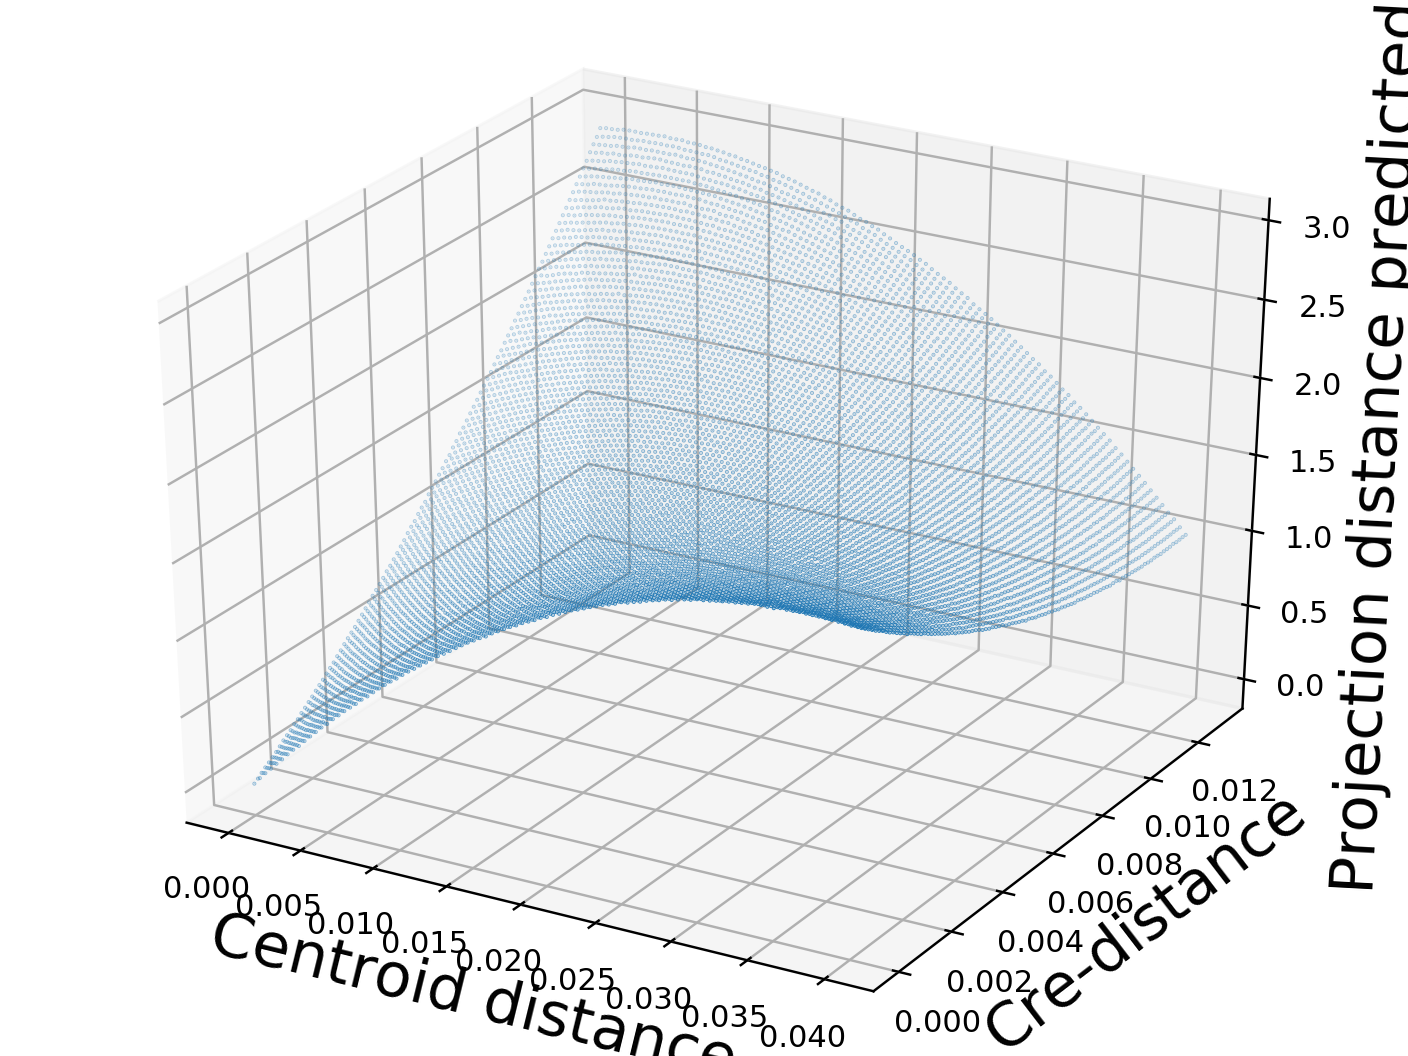

Text(0.5, 0, 'Projection distance predicted')

In [51]:
qqq = get_loss_surface(msvd, cre_dist2,frac_learn[m])

cs = cre_dist2
fraction = .01
#ls = pairwise_distances(msvd.reg_proj_vcount_norm_renorm)**2
nsamp = msvd.centroids.shape[0]
#need source and target color
source = np.repeat(np.linspace(0,nsamp - 1, nsamp, dtype = int), nsamp)
target = np.tile(np.linspace(0,nsamp - 1, nsamp, dtype = int), nsamp)
goodpairs = np.asarray(np.where(~np.isnan(cs))).transpose()
ngp = goodpairs.shape[0]
centroids = msvd.centroids
projs = msvd.reg_proj_vcount_norm_renorm
ds2 = np.zeros(ngp)
ls2 = np.zeros(ngp)
for i in range(ngp):
    #print(i)
    ds2[i] = np.linalg.norm(centroids[goodpairs[i][0]] - centroids[goodpairs[i][1]])**2
    ls2[i] = np.linalg.norm(projs[goodpairs[i][0]] - projs[goodpairs[i][1]])**2

cs2 = cs[np.where(~np.isnan(cs))]    
#ds2 = ds[np.where(~np.isnan(cs))]
#
source2 = source[np.where(~np.isnan(cs.flatten()))]
target2 = target[np.where(~np.isnan(cs.flatten()))]

dsnorm  = np.linalg.norm(ds2)
csnorm = np.linalg.norm(cs2)

ds2 = ds2 / dsnorm
cs2 = cs2 / csnorm
#ls2 = ls[np.where(~np.isnan(cs))]

dc = np.asarray([ds2,cs2,ls2]).transpose()
#ids = np.linspace(0,35, 36, dtype = int), 36)

#qqq = NadarayaWatson(kernel='rbf',  gamma  = 100)
randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
#qqq.fit(dc[:,:2][randos], dc[:,2:][randos])
xs = np.linspace(0, dc[:,0].max(), 100)
ys = np.linspace(0, dc[:,1].max(), 100)
preds = np.empty((100,100))
for x in range(100):
    for y in range(100):
        preds[x,y] =qqq.predict(np.asarray([[xs[x], ys[y]]]))#asdf.predict(np.asarray([[xs[x], ys[y]]])) #qqq.predict(np.asarray([[xs[x], ys[y]]]))
        
        
        
mxy = np.asarray(np.meshgrid(xs,ys)).transpose()

#%matplotlib inline
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(mxy[:,:,0], 
           mxy[:,:,1], 
           preds, s= .1)

#ax.set_axis_off()
ax.set_xlabel('Centroid distance', fontsize=20, rotation=150)
ax.set_ylabel('Cre-distance', fontsize=20, rotation=150)
ax.set_zlabel('Projection distance predicted', fontsize=20, rotation=150)

<IPython.core.display.Javascript object>


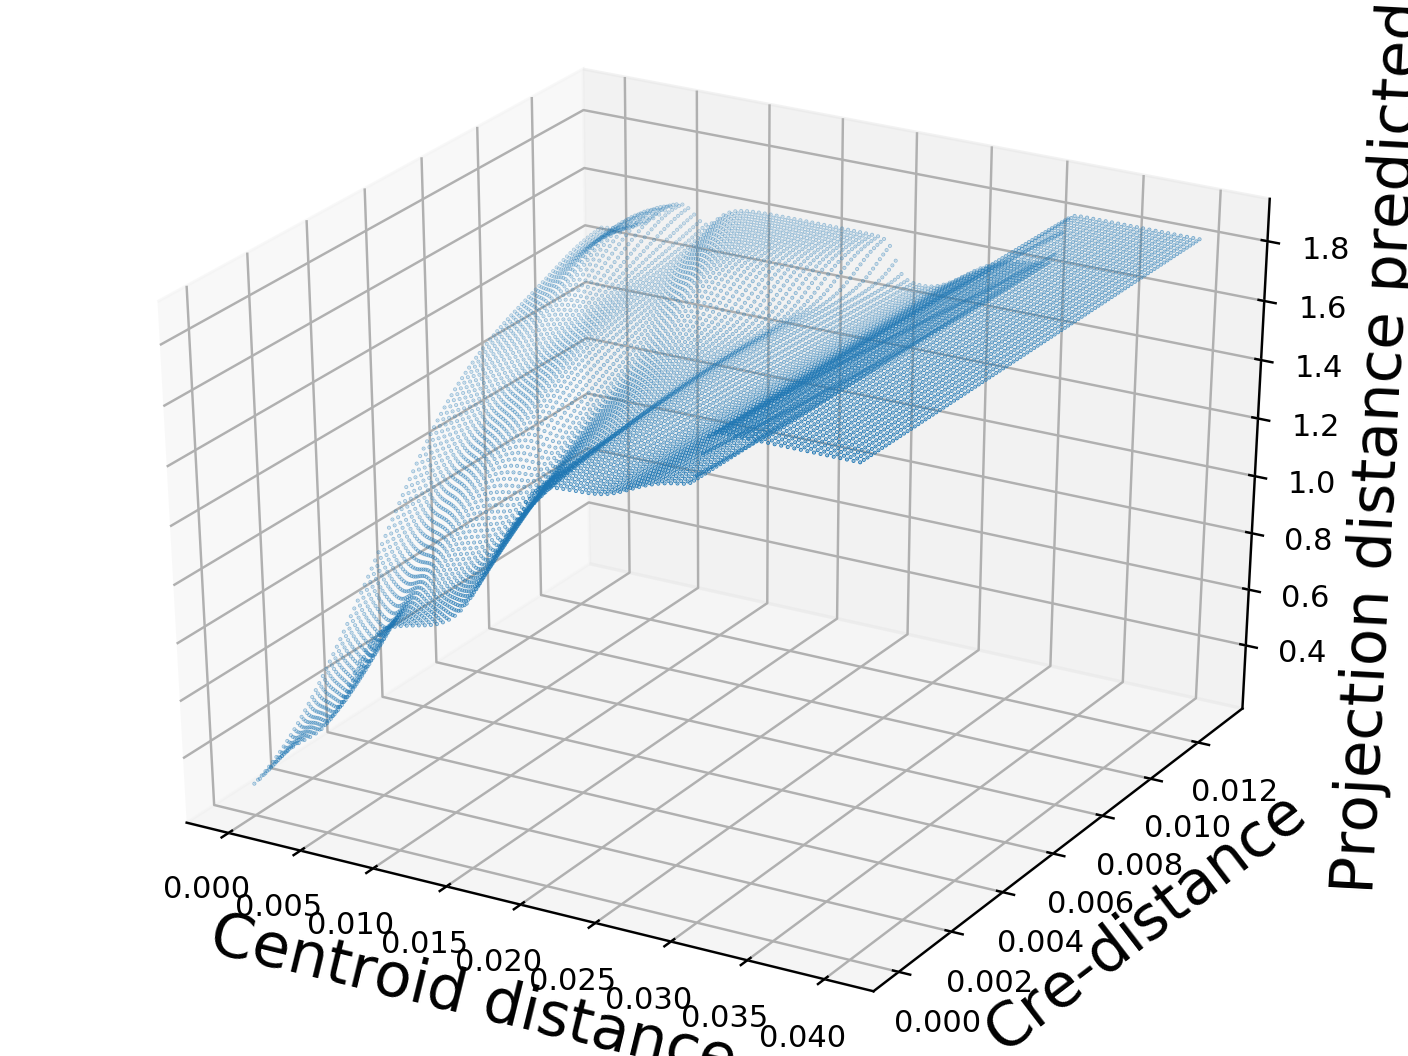

Text(0.5, 0, 'Projection distance predicted')

In [52]:

qqq = NadarayaWatson(kernel='rbf',  gamma  = 200000)
randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
qqq.fit(dc[:,:2][randos], dc[:,2:][randos])
xs = np.linspace(0, dc[:,0].max(), 100)
ys = np.linspace(0, dc[:,1].max(), 100)
preds = np.empty((100,100))
for x in range(100):
    for y in range(100):
        preds[x,y] =qqq.predict(np.asarray([[xs[x], ys[y]]]))#asdf.predict(np.asarray([[xs[x], ys[y]]])) #qqq.predict(np.asarray([[xs[x], ys[y]]]))
        
        
        
mxy = np.asarray(np.meshgrid(xs,ys)).transpose()

#%matplotlib inline
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(mxy[:,:,0], 
           mxy[:,:,1], 
           preds, s= .1)

#ax.set_axis_off()
ax.set_xlabel('Centroid distance', fontsize=20, rotation=150)
ax.set_ylabel('Cre-distance', fontsize=20, rotation=150)
ax.set_zlabel('Projection distance predicted', fontsize=20, rotation=150)

In [53]:
from mcmodels.regressors import NadarayaWatson

In [55]:
sls = {}
sls[sid] = get_smoothed_losses(msvd,qqq, cre_dist2)

In [62]:
gammas = np.asarray([0.1,.5,1,2,10])
for sid in major_structure_ids[4:5]:
    msvds[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge_dists(msvds[sid].reg_proj_vcount_norm_renorm, 
                                                                                       sls[sid], 
                                                                                       gammas, 
                                                                                       indices_leaf2ormore[sid], 
                                                                                       indices_leaf2ormore[sid])
a= [list(range(5))]
keys = np.asarray(list(itertools.product(*a)))

reg_proj_vcount_norm_renorms= {}
nwloocv_leaf_leaf2 = {}
for sid in major_structure_ids[4:5]:
    reg_proj_vcount_norm_renorms[sid ] = msvds[sid].reg_proj_vcount_norm_renorm
    nwloocv_leaf_leaf2[sid] = msvds[sid].loocv_predictions_leaf_leaf2

eval_indices_creleaf2ormore = get_eval_indices(indices_creleaf2ormore)

losses_leaf_leaf2 = get_loss(reg_proj_vcount_norm_renorms, nwloocv_leaf_leaf2,pred_ind = eval_indices_creleaf2ormore, true_ind = eval_indices_creleaf2ormore,keys = keys)
best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
meanloss_nw_leaf_leaf2 = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

(119, 5, 1128, 577)
0


In [63]:
meanloss_nw_leaf_leaf2

array([0.25156404])

In [42]:
meanloss_nw_leaf_leaf2

array([0.26210923])

(array([5.177e+03, 3.179e+03, 2.434e+03, 2.094e+03, 1.869e+03, 1.579e+03,
        1.479e+03, 1.443e+03, 1.355e+03, 1.205e+03, 1.130e+03, 1.087e+03,
        9.460e+02, 9.250e+02, 8.100e+02, 7.340e+02, 6.470e+02, 6.020e+02,
        5.460e+02, 5.130e+02, 4.480e+02, 3.960e+02, 3.960e+02, 3.560e+02,
        3.830e+02, 3.020e+02, 3.090e+02, 2.960e+02, 2.400e+02, 2.130e+02,
        1.710e+02, 1.780e+02, 1.780e+02, 1.400e+02, 1.690e+02, 1.510e+02,
        1.530e+02, 1.100e+02, 8.600e+01, 8.800e+01, 1.010e+02, 8.800e+01,
        6.500e+01, 8.800e+01, 6.000e+01, 3.900e+01, 5.700e+01, 4.600e+01,
        3.800e+01, 3.800e+01, 4.400e+01, 4.600e+01, 3.700e+01, 2.700e+01,
        2.900e+01, 3.100e+01, 3.300e+01, 2.900e+01, 2.500e+01, 2.700e+01,
        2.100e+01, 2.600e+01, 2.400e+01, 1.400e+01, 2.000e+01, 1.800e+01,
        1.800e+01, 1.600e+01, 1.300e+01, 7.000e+00, 1.300e+01, 1.700e+01,
        1.000e+01, 1.100e+01, 2.000e+01, 1.000e+01, 1.900e+01, 1.000e+01,
        1.300e+01, 1.400e+01, 1.800e+0

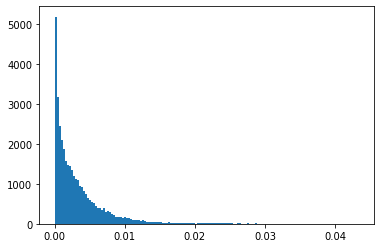

In [44]:
%matplotlib inline
plt.hist(dc[:,0], bins = 150)

Text(0.5, 0, 'Projection distance predicted')

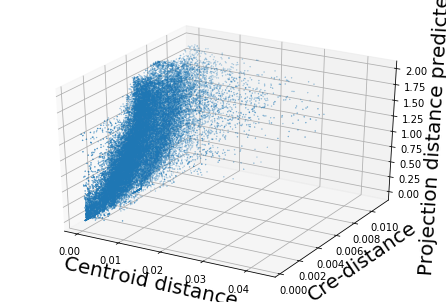

In [45]:

# qqq = NadarayaWatson(kernel='rbf',  gamma  = 200000)
# randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
# qqq.fit(dc[:,:2][randos], dc[:,2:][randos])
# xs = np.linspace(0, dc[:,0].max(), 100)
# ys = np.linspace(0, dc[:,1].max(), 100)
# preds = np.empty((100,100))
# for x in range(100):
#     for y in range(100):
#         preds[x,y] =qqq.predict(np.asarray([[xs[x], ys[y]]]))#asdf.predict(np.asarray([[xs[x], ys[y]]])) #qqq.predict(np.asarray([[xs[x], ys[y]]]))
        
        
        
# mxy = np.asarray(np.meshgrid(xs,ys)).transpose()

#%matplotlib inline
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(dc[:,0], 
           dc[:,1], 
           dc[:,2], s= .1)

#ax.set_axis_off()
ax.set_xlabel('Centroid distance', fontsize=20, rotation=150)
ax.set_ylabel('Cre-distance', fontsize=20, rotation=150)
ax.set_zlabel('Projection distance predicted', fontsize=20, rotation=150)

<IPython.core.display.Javascript object>


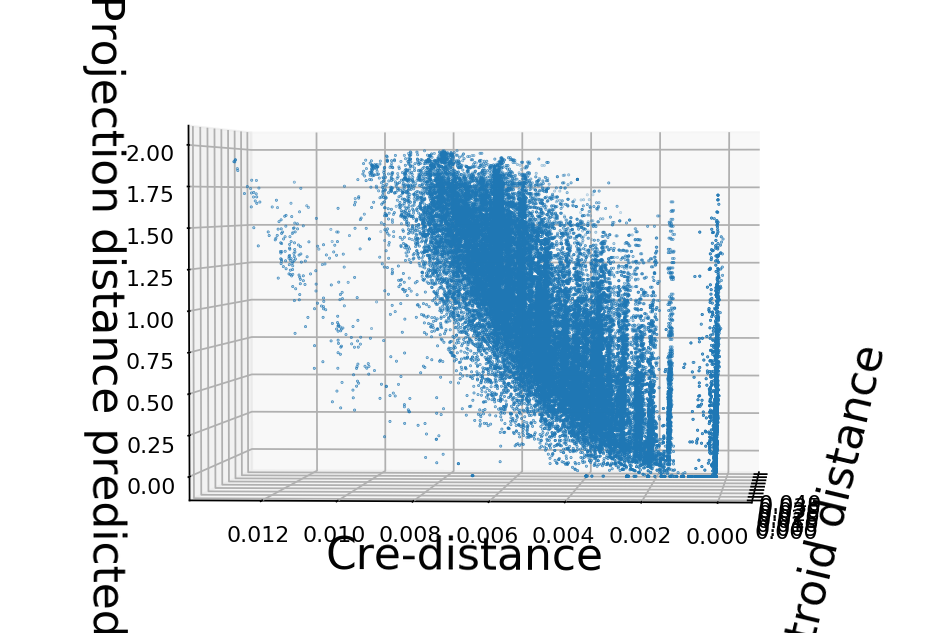

Text(0.5, 0, 'Projection distance predicted')

In [73]:
%matplotlib notebook
# qqq = NadarayaWatson(kernel='rbf',  gamma  = 200000)
# randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
# qqq.fit(dc[:,:2][randos], dc[:,2:][randos])
# xs = np.linspace(0, dc[:,0].max(), 100)
# ys = np.linspace(0, dc[:,1].max(), 100)
# preds = np.empty((100,100))
# for x in range(100):
#     for y in range(100):
#         preds[x,y] =qqq.predict(np.asarray([[xs[x], ys[y]]]))#asdf.predict(np.asarray([[xs[x], ys[y]]])) #qqq.predict(np.asarray([[xs[x], ys[y]]]))
        
        
        
# mxy = np.asarray(np.meshgrid(xs,ys)).transpose()

#%matplotlib inline
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(dc[:,0], 
           dc[:,1], 
           dc[:,2], s= .1)

#ax.set_axis_off()
ax.set_xlabel('Centroid distance', fontsize=20, rotation=150)
ax.set_ylabel('Cre-distance', fontsize=20, rotation=150)
ax.set_zlabel('Projection distance predicted', fontsize=20, rotation=150)